# Proyecto Final (Logística para la Fórmula 1)

**Materia:** Matemáticas Discretas  
**Alumno:** Axel Daniel Malváez Flores  
5to Semestre de la Licenciatura en Ciencia de Datos

## Objetivo del Proyecto

Se tiene como objetivo hacer un plan de viaje para la siguiente temporada de la Fórmula 1. Recorreremos varias ciudades en distintos países y determinaremos cual es la mejor fórma de tener 24 carreras, preferiblemente en países distintos de forma que el recorrido (distancia entre circuitos) sea mínima, esto debido a los altos costos que nos genera transportar las herramientas necesarias para el funcionamiento del equipo en un Grand Prix.   

Añadiremos ciertas métricas que también descartarán circuitos tales como circuitos que ya no tienen contrato o aquellos Grand Prixes que generen un derrame económico alto (usando fuentes externas).

## Recursos

### Data Set
El data set fue obtenido de *Kaggle* en el siguiente link : https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

### Fuentes de Información

Las siguientes fueron las fuentes de información de las cuales me ayudé para el desarrollo y la implementación de este proyecto. Son links de consulta que nos dirigen a páginas principalmente de documentación para la ayuda de implementación de funciones.

**Graficar la ubicación de los circuitos en un mapa (interactivo)**
* https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
* https://geopandas.org/en/stable/gallery/plotting_with_folium.html
* https://python.plainenglish.io/using-folium-to-map-latitude-and-longitude-491f8dcc81ad
* https://geopandas.org/en/stable/docs/user_guide/mapping.html
* https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
* https://stackoverflow.com/questions/63722124/get-distance-between-two-points-in-geopandas
* https://fontawesome.com/icons?d=gallery

**Dibujar gráficas ponderadas**
* https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html
* https://networkx.org/documentation/stable/auto_examples/drawing/plot_node_colormap.html

**Implementación de algoritmos NetworkX**
* https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.tree.mst.minimum_spanning_tree.html
* https://networkx.org/documentation/stable/reference/algorithms/approximation.html#module-networkx.algorithms.approximation.traveling_salesman
* https://madi.nekomath.com/P5/ArbolPesoMin.html
* https://es.wikipedia.org/wiki/Algoritmo_de_Kruskal#:~:text=El%20algoritmo%20de%20Kruskal%20es,del%20%C3%A1rbol%20es%20el%20m%C3%ADnimo.
* https://es.wikipedia.org/wiki/Algoritmo_de_Boruvka

## Exploración Data Set

Dentro de la base de datos de la **Fórmula 1**, utilizaremos el conjunto de datos correspondiente a los **circuitos** de Fórmula 1 que han albergado un Grand Prix. 

In [1]:
# Librerías importantes que utilizaremos en el proyecto
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import networkx as nx
import seaborn as sns 
import folium
sns.set()
plt.rcParams["figure.figsize"] = (15,15)

GeoDataFrame (necesario para la graficación de los puntos) cargado como *csv*. Nos muestra ciertas características de los circuitos tales como **nombre**, **ubicación** y **coordenadas**.

In [2]:
circuits = pd.read_csv('Formula1/circuits.csv').drop(['url'], axis=1)
circuits.head()

circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  
0  Australia -37.84970  144.96800   10  
1   Malaysia   2.76083  101.73800   18  
2    Bahrain  26.03250   50.51060    7  
3      Spain  41.57000    2.26111  109  
4     Turkey  40.95170   29.40500  130

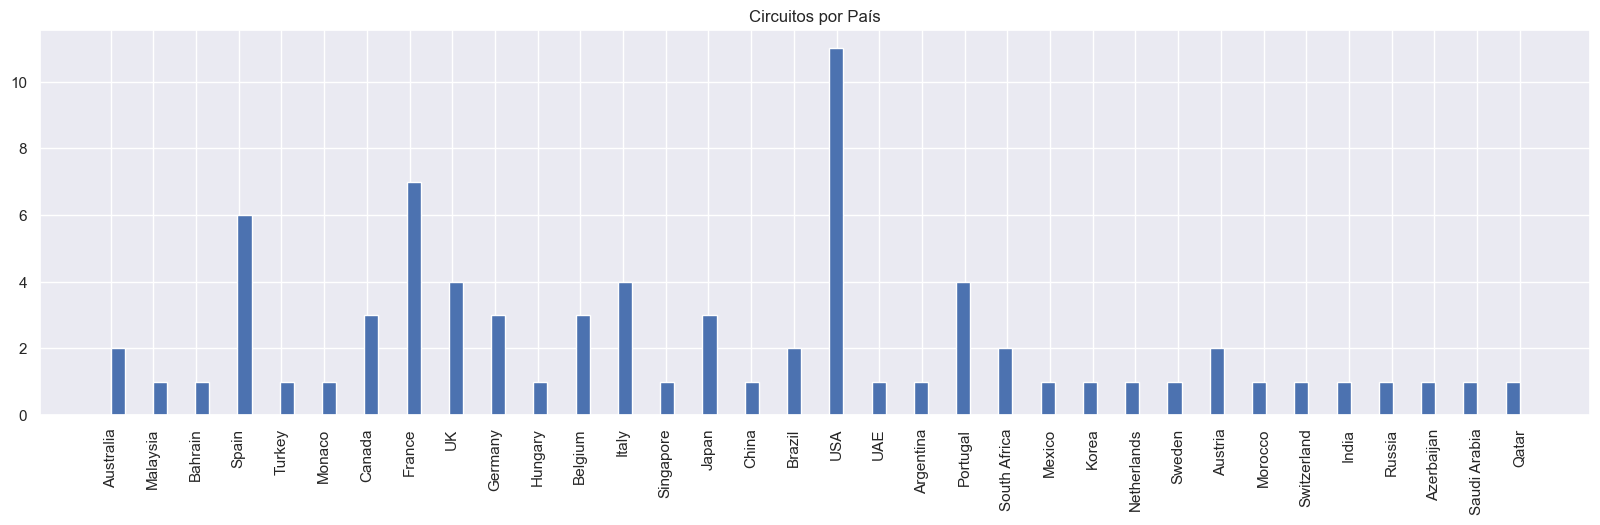

In [3]:
plt.figure(figsize=(20,5))
circuits.country.hist(bins=100)
plt.xticks(rotation=90)
plt.title('Circuitos por País')
plt.show()

## Visualización

Podemos resaltar que para poder de visualizar cada punto en el mapa, debemos de recorrer toda la columna **geometry** de nuestra tabla, lo cual toma tiempo $O(n)$ dependiendo del tamaño de la misma. No obstante la generación del mapa dado que ya es un mapa establecido en los *data sets* de *geopandas*, podremos argumentar que será constante $O(1)$.

Para poder visualizar mejor la información corresondiente al conjunto de datos anteriormente mencionado, dibujamos los circuitos dentro de un mapa mundial. Esta visualización es **útil** para determinar a *grosso modo* que el continente con mayores circuitos que albergan o albergaron un Gran Premio ha sido *Europa*, lo cuál no es novedad debido a que la Fórmula 1 es un deporte con origen en Inglaterra.

In [4]:
circuits = gpd.GeoDataFrame(circuits, geometry=gpd.points_from_xy(circuits.lng, circuits.lat))

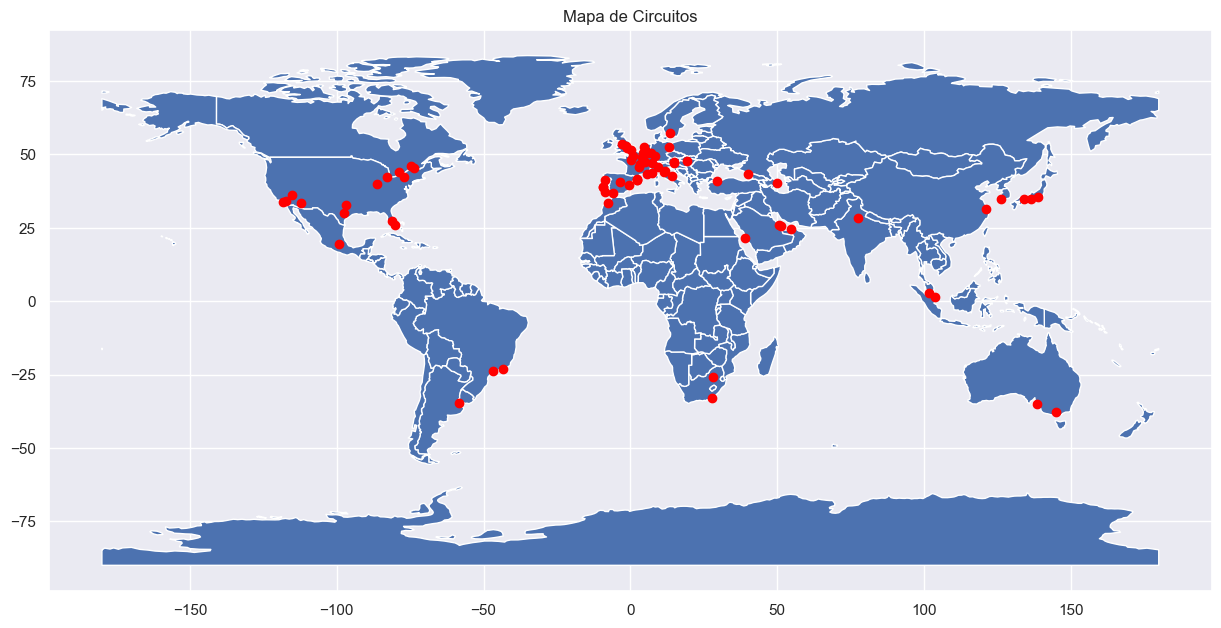

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot()
circuits.plot(ax=ax, color='red')
plt.title('Mapa de Circuitos')
plt.show()

Para una mejor visualización con respecto a la ubicación de cada uno de los circuitos de la Fórmula 1, utilizamos un mapa interactivo de la paquetería **Folium** y dentro del cuál asignamos un pin a la ubicación real de cada circuito.

In [6]:
m = folium.Map()
for _, r in circuits.iterrows():
    lat = r['geometry'].y
    lon = r['geometry'].x
    folium.Marker(icon=folium.Icon(color='blue', icon='flag-checkered', prefix='fa'),location=[lat, lon],
                  popup='Circuit Name: {} <br> Country: {}'.format(r['name'], r['country'])).add_to(m)

m

## Gráfica NetworkX

El siguiente paso será trasladar nuestros puntos mostrados en los mapas anteriores a una gráfica de NetworkX a la que podamos asignarle pesos a las aristas (distancia entre circuito y circuito) y así aplicar algoritmos correspondientes a gráficas ponderadas.

Distancias entre dos autódromos (cambiamos la métrica para que el cálculo de la misma nos la regrese en metros)

In [7]:
# Cambio de crs
circuits = circuits.set_crs('epsg:4326')
circuits = circuits.to_crs(epsg=32631)

In [8]:
# Obtenemos dos circuitos uno de Australia y otro de España
circuit_1 = circuits.loc[0]
circuit_2 = circuits.loc[3]

In [9]:
print(f'La distancia entre el circuito {circuit_1[2]} ubicado en {circuit_1[4]} y el circuito {circuit_2[2]} ubicado en {circuit_2[4]} es {(circuit_1[8].distance(circuit_2[8]) / 1000)} km')

La distancia entre el circuito Albert Park Grand Prix Circuit ubicado en Australia y el circuito Circuit de Barcelona-Catalunya ubicado en Spain es 19956.335372858866 km


Lo siguiente que haremos para poder crear nuestra gráfica será construir **diccionarios** que nos permitan interpretar nuestras gráficas y así hacer una visualización más sencilla de la misma. Elegimos esta estructura de datos debido a la complejidad en tiempo de obtener un elemento dada una llave, esto porque necesitaremos conocer en bastantes ocaciones el nombre del autódromo asociado a un número entre el $0$ y el $75$. Para lo cual hacerlo en $O(1)$ nos hace más rápida aún la búsqueda.

In [10]:
dict_circuits = {i:circuits['name'][i] for i in range(len(circuits))}

In [11]:
inverse_dict_circuits = {circuits['name'][i]:i for i in range(len(circuits))}

Para el cálculo de las distancias entre cada punto corresponde a crear una gráfica completa donde el peso de cada arista sea la distancia entre los circuitos que conecta. Dado que sabemos que una gráfica de $n$ vértices tiene a lo más 

$${n\choose{2}}$$   

aristas entonces la complejidad de crear una lista de tuplas que contenga las combinaciones de los $76$ circuitos en grupos de $2$ será de $O(2 * {n\choose 2}) = O(n^2 - n) = O(n^2)$.

In [12]:
from itertools import combinations

num_circuits = [i for i in range(76)]
comb = list(combinations(num_circuits, 2))

Después para cada combinación creamos nuestra arista y es aquí cuando aprovechamos la complejidad de obtención de elementos en nuestro diccionario debido a que para saber qué punto de qué autódromo corresponde a un cierto número en una tupla $i$ de nuestras combinaciones, necesitamos acceder a buscarlo con la llave como número.

In [13]:
G = nx.Graph()

for i in comb:
    x,y = i
    x_node = circuits[circuits['name'] == dict_circuits[x]].values[0][8]
    y_node = circuits[circuits['name'] == dict_circuits[y]].values[0][8]
    dist = x_node.distance(y_node)
    G.add_edge(x,y, weight=dist)

La creación de nuestra gráfica ponderada es un poco lenta debido a que aunado a dibuar cada una de las aristas de cada punto, también asigna ciertos atributos como colores, etiquetas y distancia en las aristas.

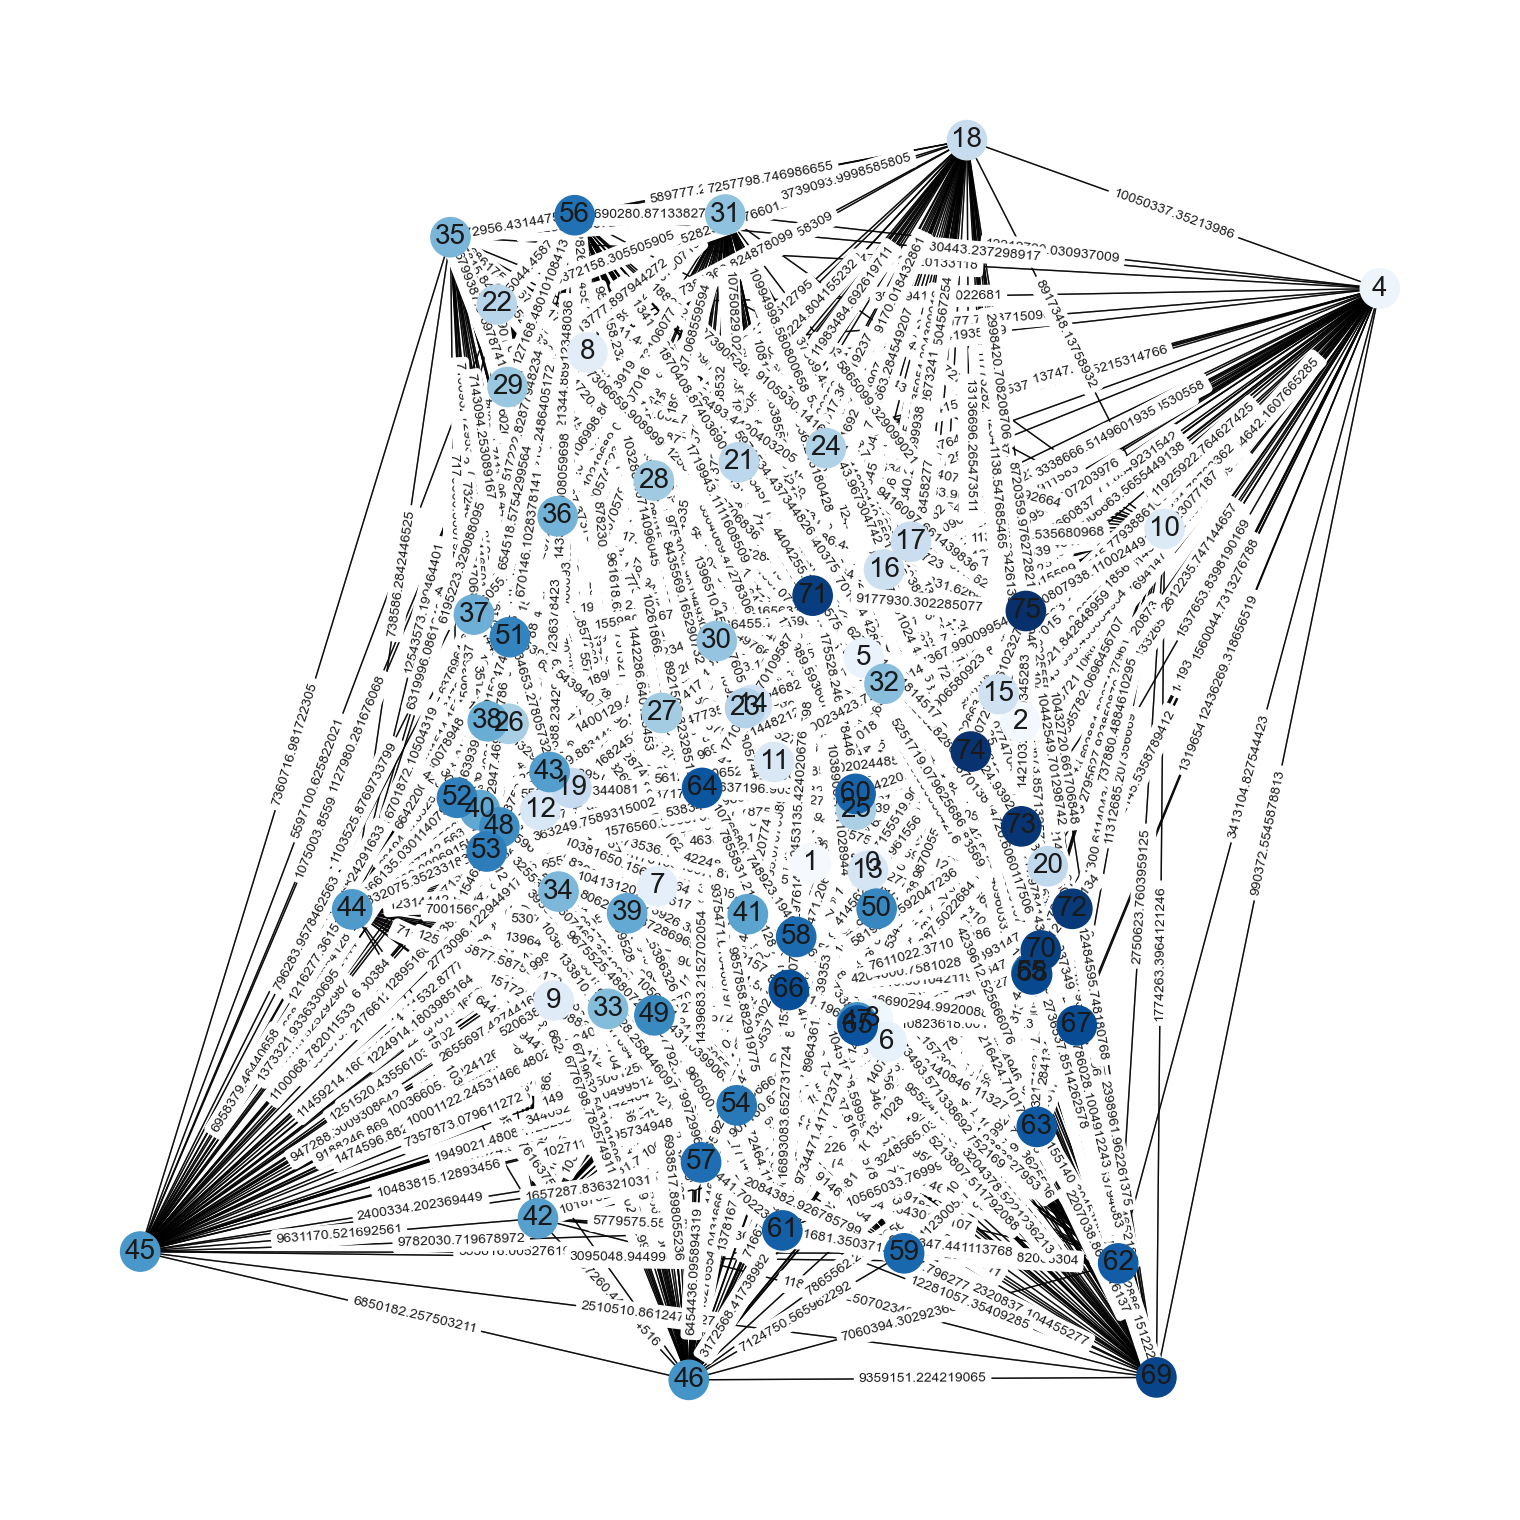

In [14]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
#nx.draw_networkx_edges(G, pos, width=6)
nx.draw_networkx_edges(
    G, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

### 24 Carreras

La gráfica anterior fue calculada con base a las distancias de los vértices todos contra todos, no obstante la temporada de 2023 constará de 24 carreras en el calendario por lo que queremos una gráfica que modele los circuitos y sus distancias entre sí para poder obtener árboles de peso mínimo y también dados los circuitos encontrar la ruta más corta posible que visite cada ciudad exactamente una vez y posiblemente regresar a la ciudad original (o no) lo cuál es bien conocido como Travelling Salesman Problem (TSP). Por tanto dado que los contratos de los Grandes Premios ya fueron firmados y ya están pactados únicamente nos hace falta trazar la ruta que recorreremos a lo largo del 2023. El listado de Grandes Premios para la temporada 2023 es la siguiente:   

* GP de Bahrein
* GP de Arabia Saudí
* GP de Australia
* GP de China
* GP de Azerbaiyán
* GP de Miami
* GP de Emilia Romagna (Italia)
* GP de Mónaco
* GP de España
* GP de Canadá
* GP de Austria
* GP de Gran Bretaña
* GP de Hungría
* GP de Bélgica
* GP de los Países Bajos
* GP de Italia
* GP de Singapur
* GP de Japón
* GP de Qatar
* GP de Estados Unidos
* GP de México
* GP de Brasil
* GP de Las Vegas
* GP de Abu Dhabi

Fuentes:

* https://www.formula1.com/en/latest/article.f1-announces-24-race-calendar-for-2023.7oNRaq4kZ2bwTAmL7r6dqg.html
* https://es.motorsport.com/f1/news/fia-aprueba-calendario-record-formula1-2023/10372005/

In [15]:
circuits.country.unique()

array(['Australia', 'Malaysia', 'Bahrain', 'Spain', 'Turkey', 'Monaco',
       'Canada', 'France', 'UK', 'Germany', 'Hungary', 'Belgium', 'Italy',
       'Singapore', 'Japan', 'China', 'Brazil', 'USA', 'UAE', 'Argentina',
       'Portugal', 'South Africa', 'Mexico', 'Korea', 'Netherlands',
       'Sweden', 'Austria', 'Morocco', 'Switzerland', 'India', 'Russia',
       'Azerbaijan', 'Saudi Arabia', 'Qatar'], dtype=object)

Creamos un índice para poder iterar la tabla fácilmente

In [16]:
index = [i for i in range(76)]
circuits['index'] = index

In [17]:
countries_24 = ['Saudi Arabia', 'Australia', 'China', 'Azerbaijan', 'USA', 'Italy', 
                'Monaco', 'Spain', 'Canada', 'Austria', 'UK', 'Hungary', 'Belgium', 
                'Netherlands', 'Singapore', 'Japan', 'Qatar', 'Mexico', 'Brazil', 'UAE']
countries_notrep = ['Saudi Arabia', 'China', 'Azerbaijan', 'Monaco', 'Hungary', 
                    'Netherlands', 'Singapore', 'Qatar', 'Mexico', 'UAE']

circuits_24 = circuits[circuits['country'] == 'Bahrain']
lista_ids = list(circuits.index)

for i in lista_ids:
    circuit = circuits[circuits['index'] == i]
    if circuit['country'][i] in countries_24:
        if circuit['country'][i] in countries_notrep :
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Australia' and circuit['name'][i] == 'Albert Park Grand Prix Circuit':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'USA' and circuit['name'][i] == 'Miami International Autodrome':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'USA' and circuit['name'][i] == 'Las Vegas Street Circuit':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Italy' and circuit['name'][i] == 'Autodromo Enzo e Dino Ferrari':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Italy' and circuit['name'][i] == 'Autodromo Nazionale di Monza':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Spain' and circuit['name'][i] == 'Circuit de Barcelona-Catalunya':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Canada' and circuit['name'][i] == 'Circuit Gilles Villeneuve':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Austria' and circuit['name'][i] == 'Red Bull Ring':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'UK' and circuit['name'][i] == 'Silverstone Circuit':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Belgium' and circuit['name'][i] == 'Circuit de Spa-Francorchamps':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Japan' and circuit['name'][i] == 'Suzuka Circuit':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'Brazil' and circuit['name'][i] == 'Autódromo José Carlos Pace':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)
        if circuit['country'][i] == 'USA' and circuit['name'][i] == 'Circuit of the Americas':
            circuits_24 = pd.concat([circuits_24, circuit], axis=0)


**Creamos nuestra nueva gráfica correspondiente a los 24 circuitos de la temporada 2023**

In [18]:
num_circuits = []
ci = list(circuits_24.name)
for n, c in list(dict_circuits.items()):
    if c in ci:
        num_circuits.append(n)

In [19]:
comb_24 = list(combinations(num_circuits, 2))

G_24 = nx.Graph()

for i in comb_24:
    x,y = i
    x_node = circuits_24[circuits_24['name'] == dict_circuits[x]].values[0][8]
    y_node = circuits_24[circuits_24['name'] == dict_circuits[y]].values[0][8]
    dist = x_node.distance(y_node)
    G_24.add_edge(x,y, weight=dist)

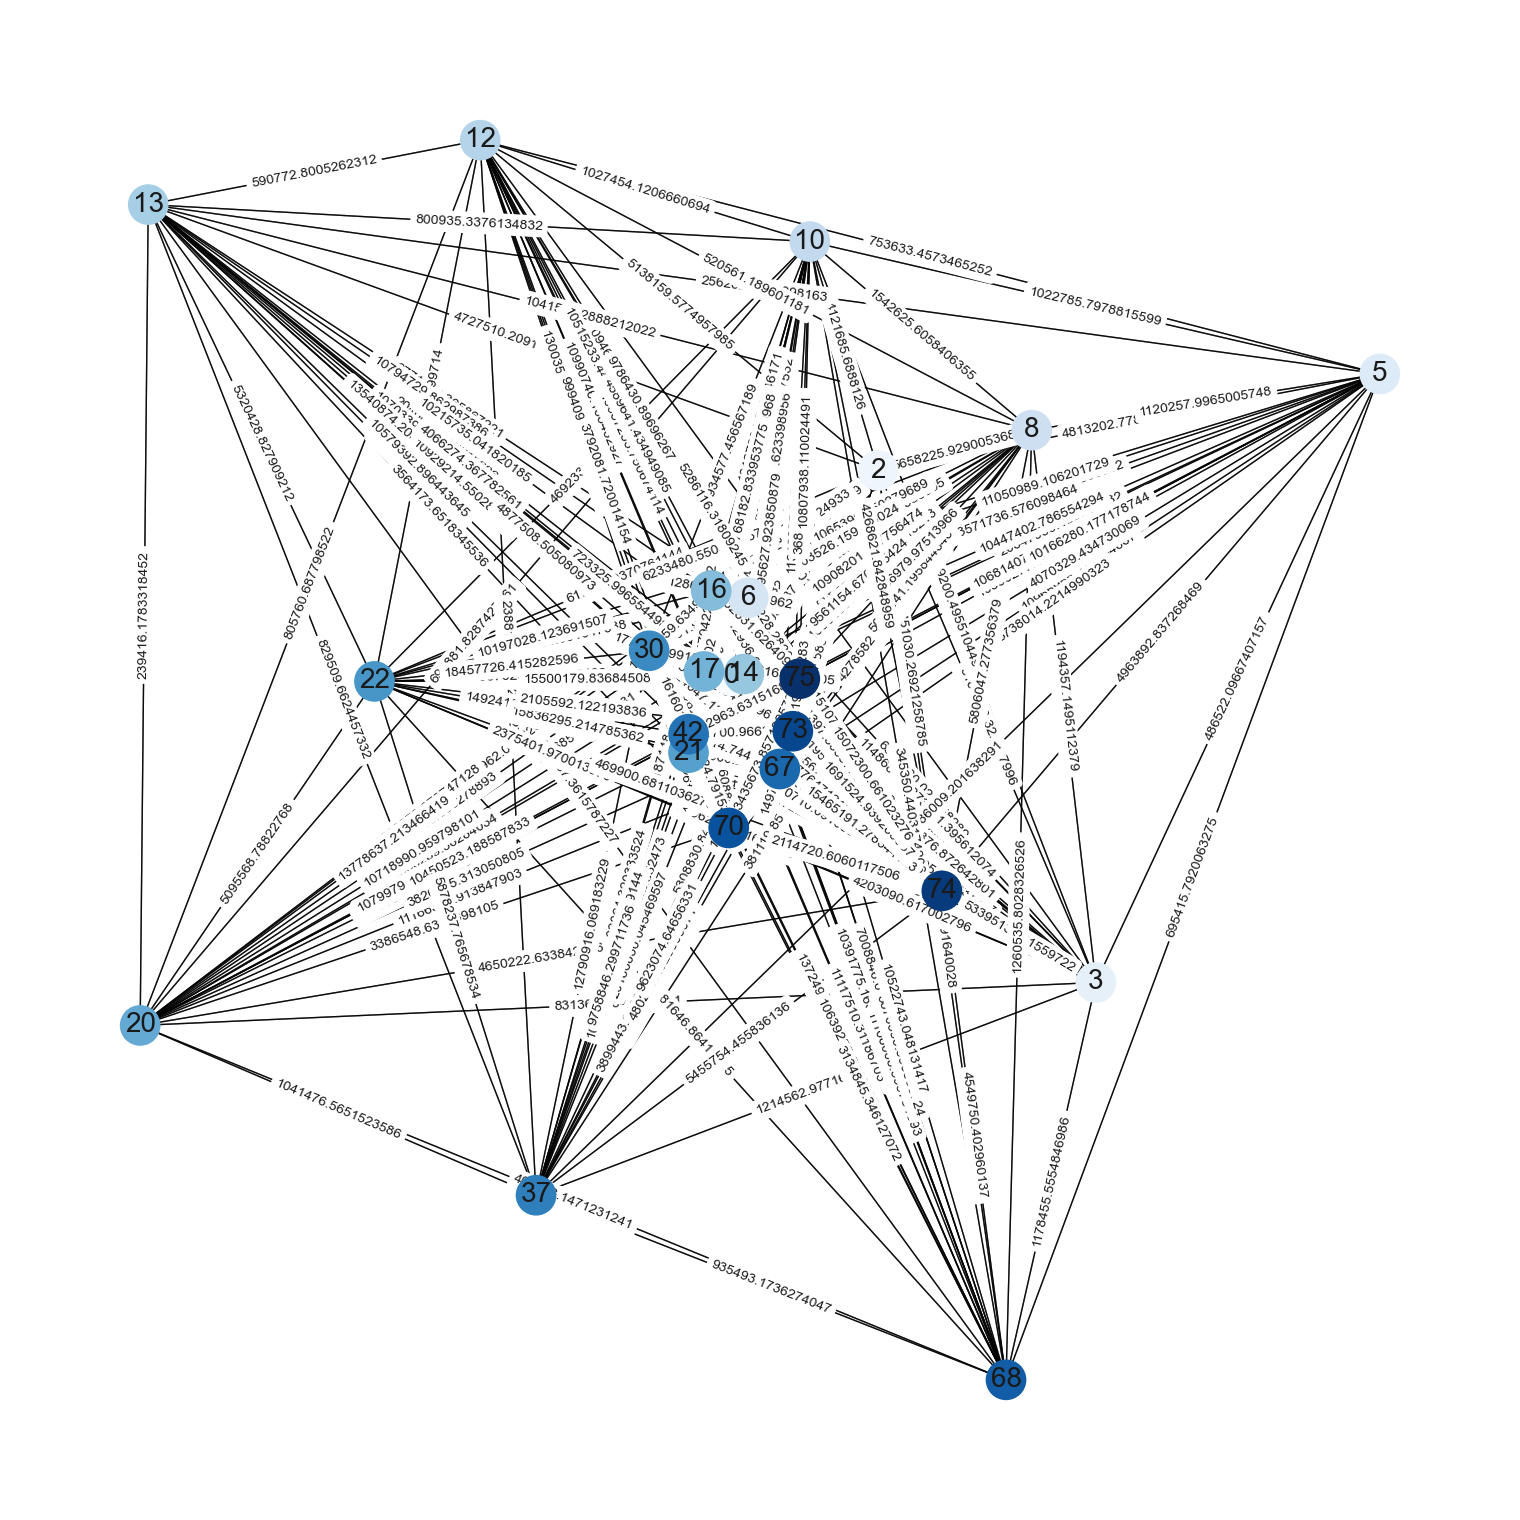

In [20]:
pos = nx.kamada_kawai_layout(G_24)
nx.draw(G_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
#nx.draw_networkx_edges(G, pos, width=6)
nx.draw_networkx_edges(
    G_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(G_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(G_24, "weight")
nx.draw_networkx_edge_labels(G_24, pos, edge_labels)

plt.show()

## Algoritmos en gráficas

Aplicaremos los siguientes algoritmos a nuestra gráfica correspondiente a los circuitos:

Algoritmos de búsqueda:
* Deepth First Search (DFS)
* Breadth First Search (BFS)

Algoritmos que encuentran el árbol generador de peso mínimo:
* Prim
* Kruskal
* Boruvka

Algoritmo que encuentra el recorrido TSP:
* Traveler Salesman Problem (TSP) algoritmo NP-Completo

### DFS

El siguiente es el árbol resultante del recorrido **DFS** de nuestra gráfica de Circuitos. Comenzamos en el circuito 0 correspondiente al 'Albert Park Grand Prix Circuit'.   

Notemos que el recorrido de DFS al ser de profundidad y hacer uso de un stack, el árbol generado con DFS recorre a la gráfica en el orden del $0-75$ esto pues como $G$ es completa, el resultado parece semejante a recorrer una lista de los números ordenados.   

Tenemos que la complejidad en tiempo del puro algoritmo **DFS** es de $O(|V| + |E|)$ con $|V| = $ **número de vértices** y $|E| = $ **número de aristas**. Esto sin el incremento de la complejidad al crear la gráfica (intuitivamente resulta ser $O(|V|)$ pues se recorre la lista que nos regresa DFS, no obstante no conocemos la complejidad de añadir un nodo y una arista, probablemente es $O(1)$).

Pseudocódigo:

```
func DFS(G, u, visitados):
    marcamos u como visitado en visitados
        para cada vertice v adyacente a u en G: 
            si v no ha sido visitado en visitados:
               marcamos como visitado v en visitados
               llamamos recursivamente DFS(G, v, visitados)  
```

#### Gráfica 76 Circuitos

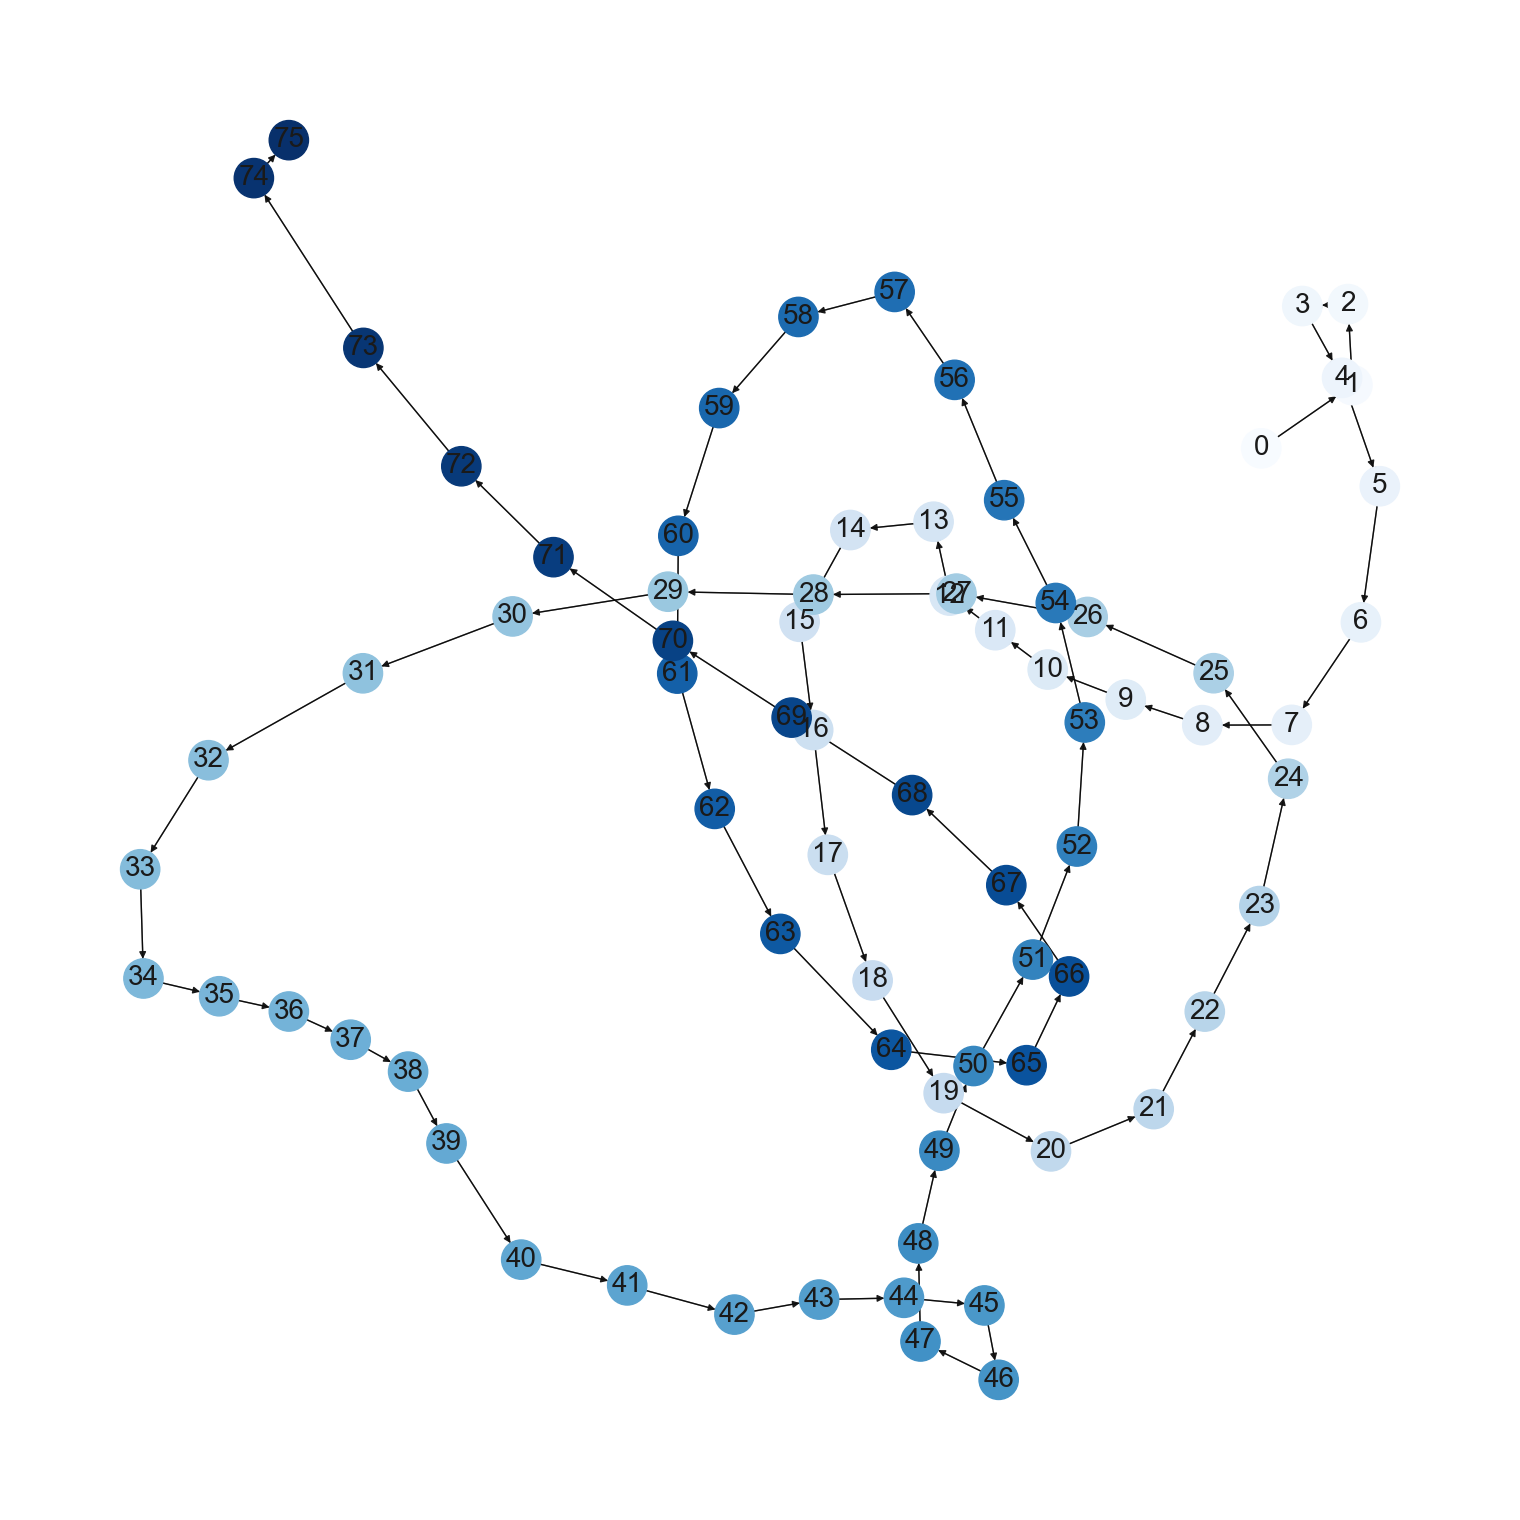

In [21]:
dfs_graph = nx.dfs_tree(G, 0)
pos = nx.spring_layout(dfs_graph, seed=76)
nx.draw(dfs_graph, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    dfs_graph, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(dfs_graph, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(dfs_graph, "weight")
nx.draw_networkx_edge_labels(dfs_graph, pos, edge_labels)

plt.show()

#### Gráfica 24 Circuitos

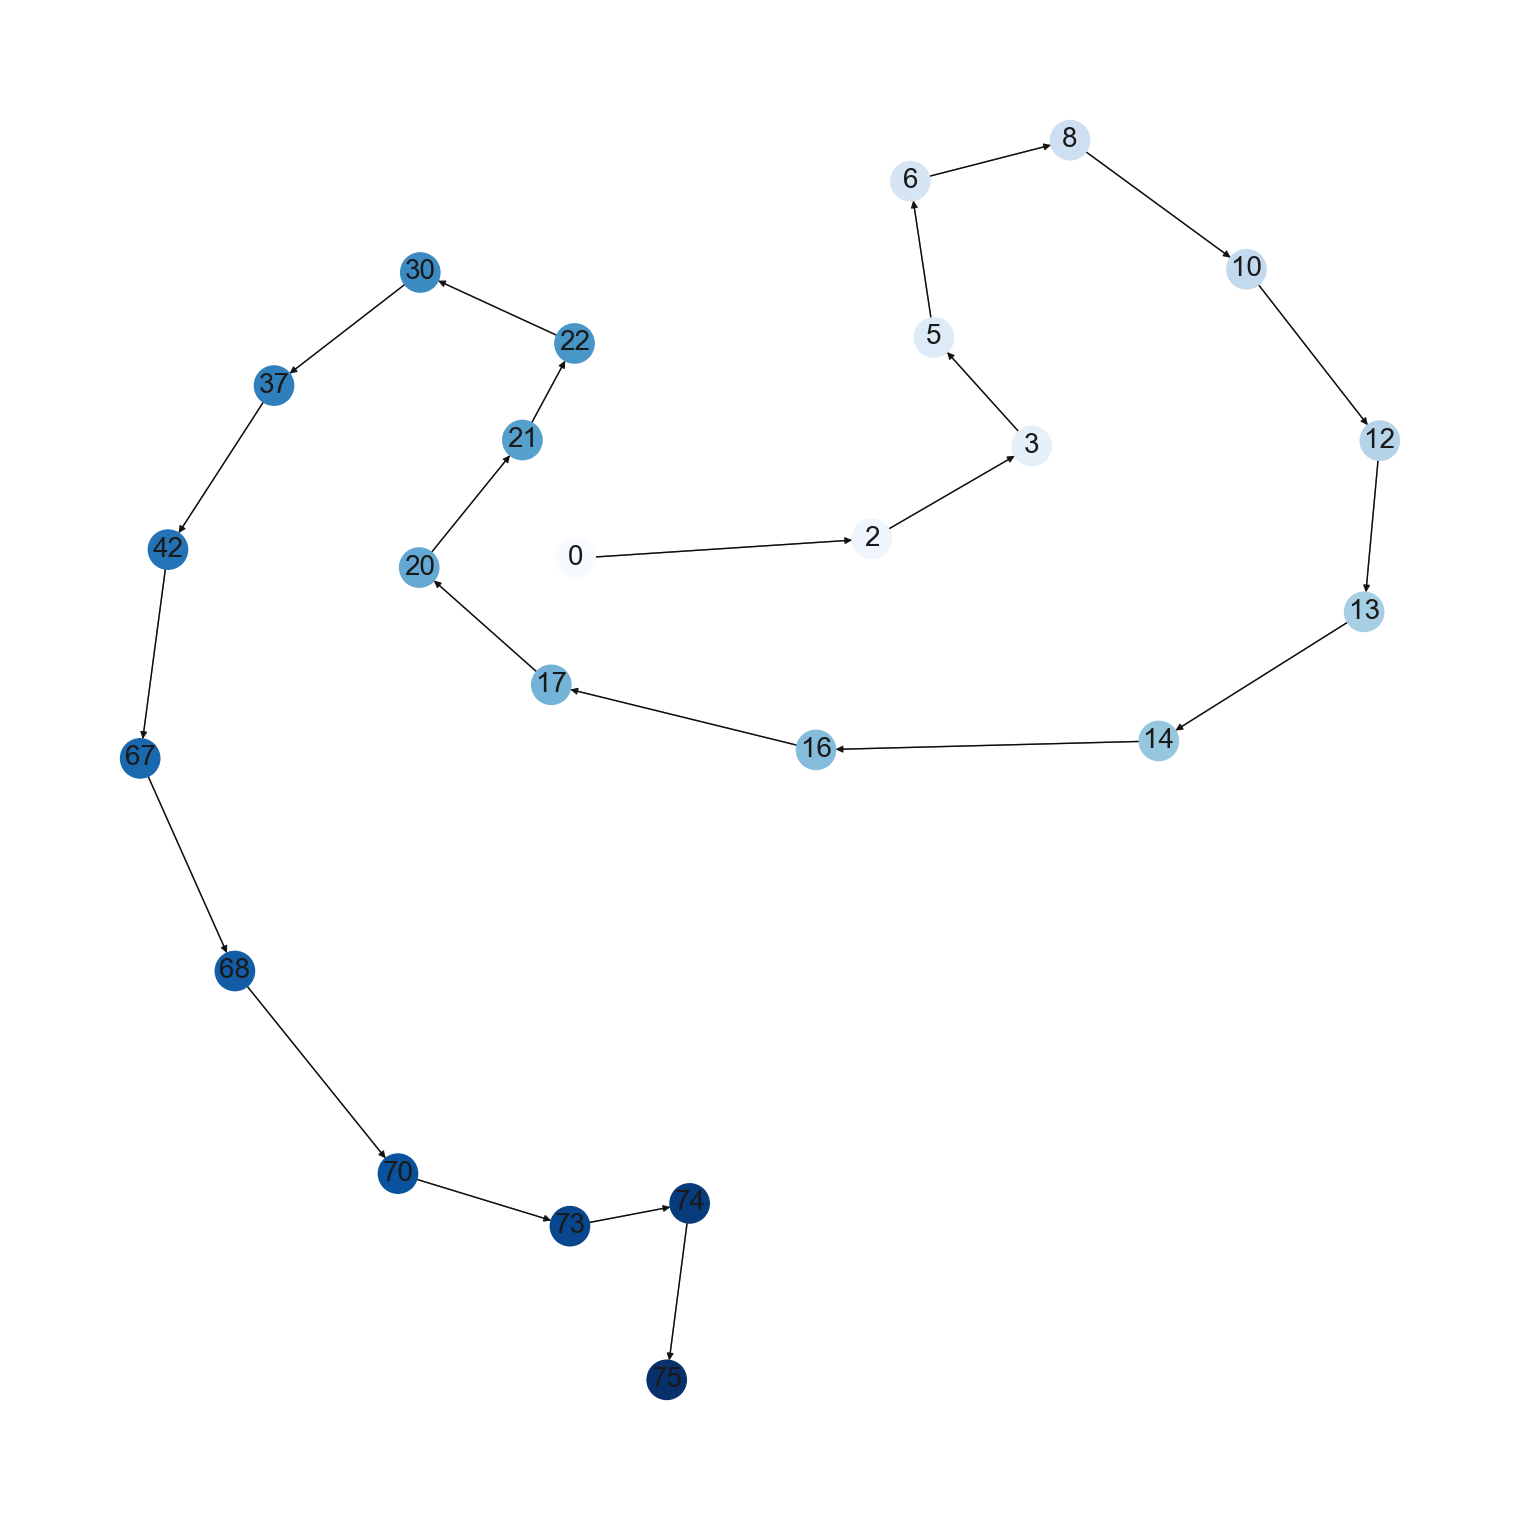

In [22]:
dfs_graph_24 = nx.dfs_tree(G_24, 0)
pos = nx.spring_layout(dfs_graph_24, seed=76)
nx.draw(dfs_graph_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    dfs_graph_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(dfs_graph_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(dfs_graph_24, "weight")
nx.draw_networkx_edge_labels(dfs_graph_24, pos, edge_labels)

plt.show()

### BFS

El siguiente es el árbol resultante del recorrido **BFS** de nuestra gráfica de Circuitos. Comenzamos en el circuito $0$ correspondiente al 'Albert Park Grand Prix Circuit'.   

Notemos que el recorrido de BFS al ser realizado por anchura y hacer uso de una cola, el árbol generado con BFS recorre a todos primero a todos los vecinos del vértice $0$, no obstante dado que la gráfica es completa, es por esto que se ve como un círculo donde el centro es el $0$ y sus demás hijos son los vértices restantes.

Tenemos que la complejidad en tiempo del puro algoritmo **DFS** es de $O(|V| + |E|)$ suponiendo que vemos a nuestra gráfica como una lista de adyacencias siendo $|V| = $ **número de vértices** y $|E| = $ **número de aristas**. Esto sin el incremento de la complejidad al crear la gráfica (intuitivamente resulta ser $O(|V|)$ pues se recorre la lista que nos regresa DFS, no obstante no conocemos la complejidad de añadir un nodo y una arista, probablemente es $O(1)$).   

Pseudocódigo:

```
func BFS(G,v):
    creamos una cola Q
    creamos una lista visitados
    añadimos v a la cola Q
    marcamos v como visitado en visitados
    mientras Q no este vacío:
        sacamos un elemento v de la cola Q
        para cada vertice w adyacente a v en la gráfica: 
            si w no ha sido visitado:
               marcamos como visitado w en visitados
                insertamos w dentro de la cola Q
```

#### Gráfica 76 Circuitos

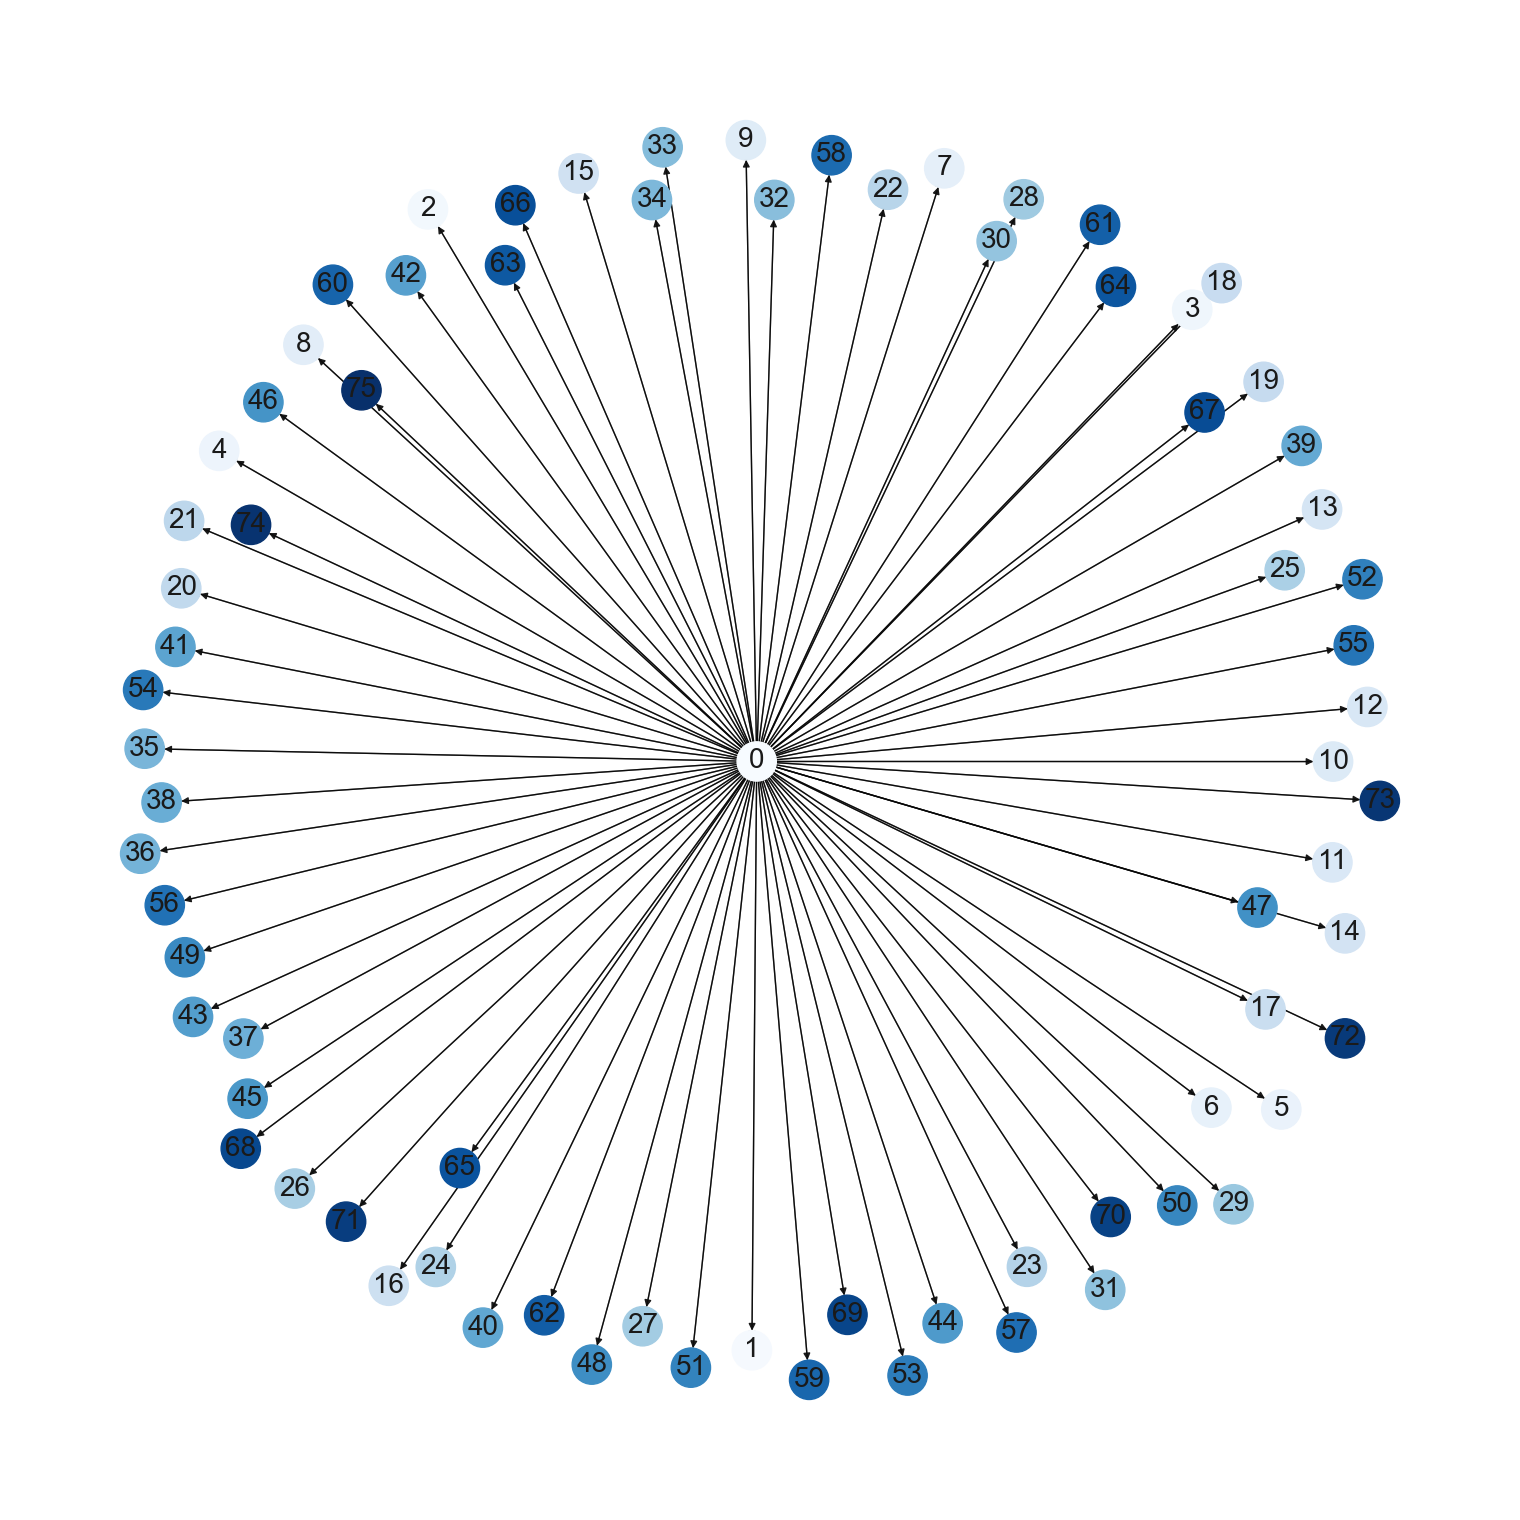

In [23]:
bfs_graph = nx.bfs_tree(G, 0)
pos = nx.spring_layout(bfs_graph, seed=76)
nx.draw(bfs_graph, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    bfs_graph, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(bfs_graph, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(bfs_graph, "weight")
nx.draw_networkx_edge_labels(bfs_graph, pos, edge_labels)

plt.show()

#### Gráfica 24 Circuitos

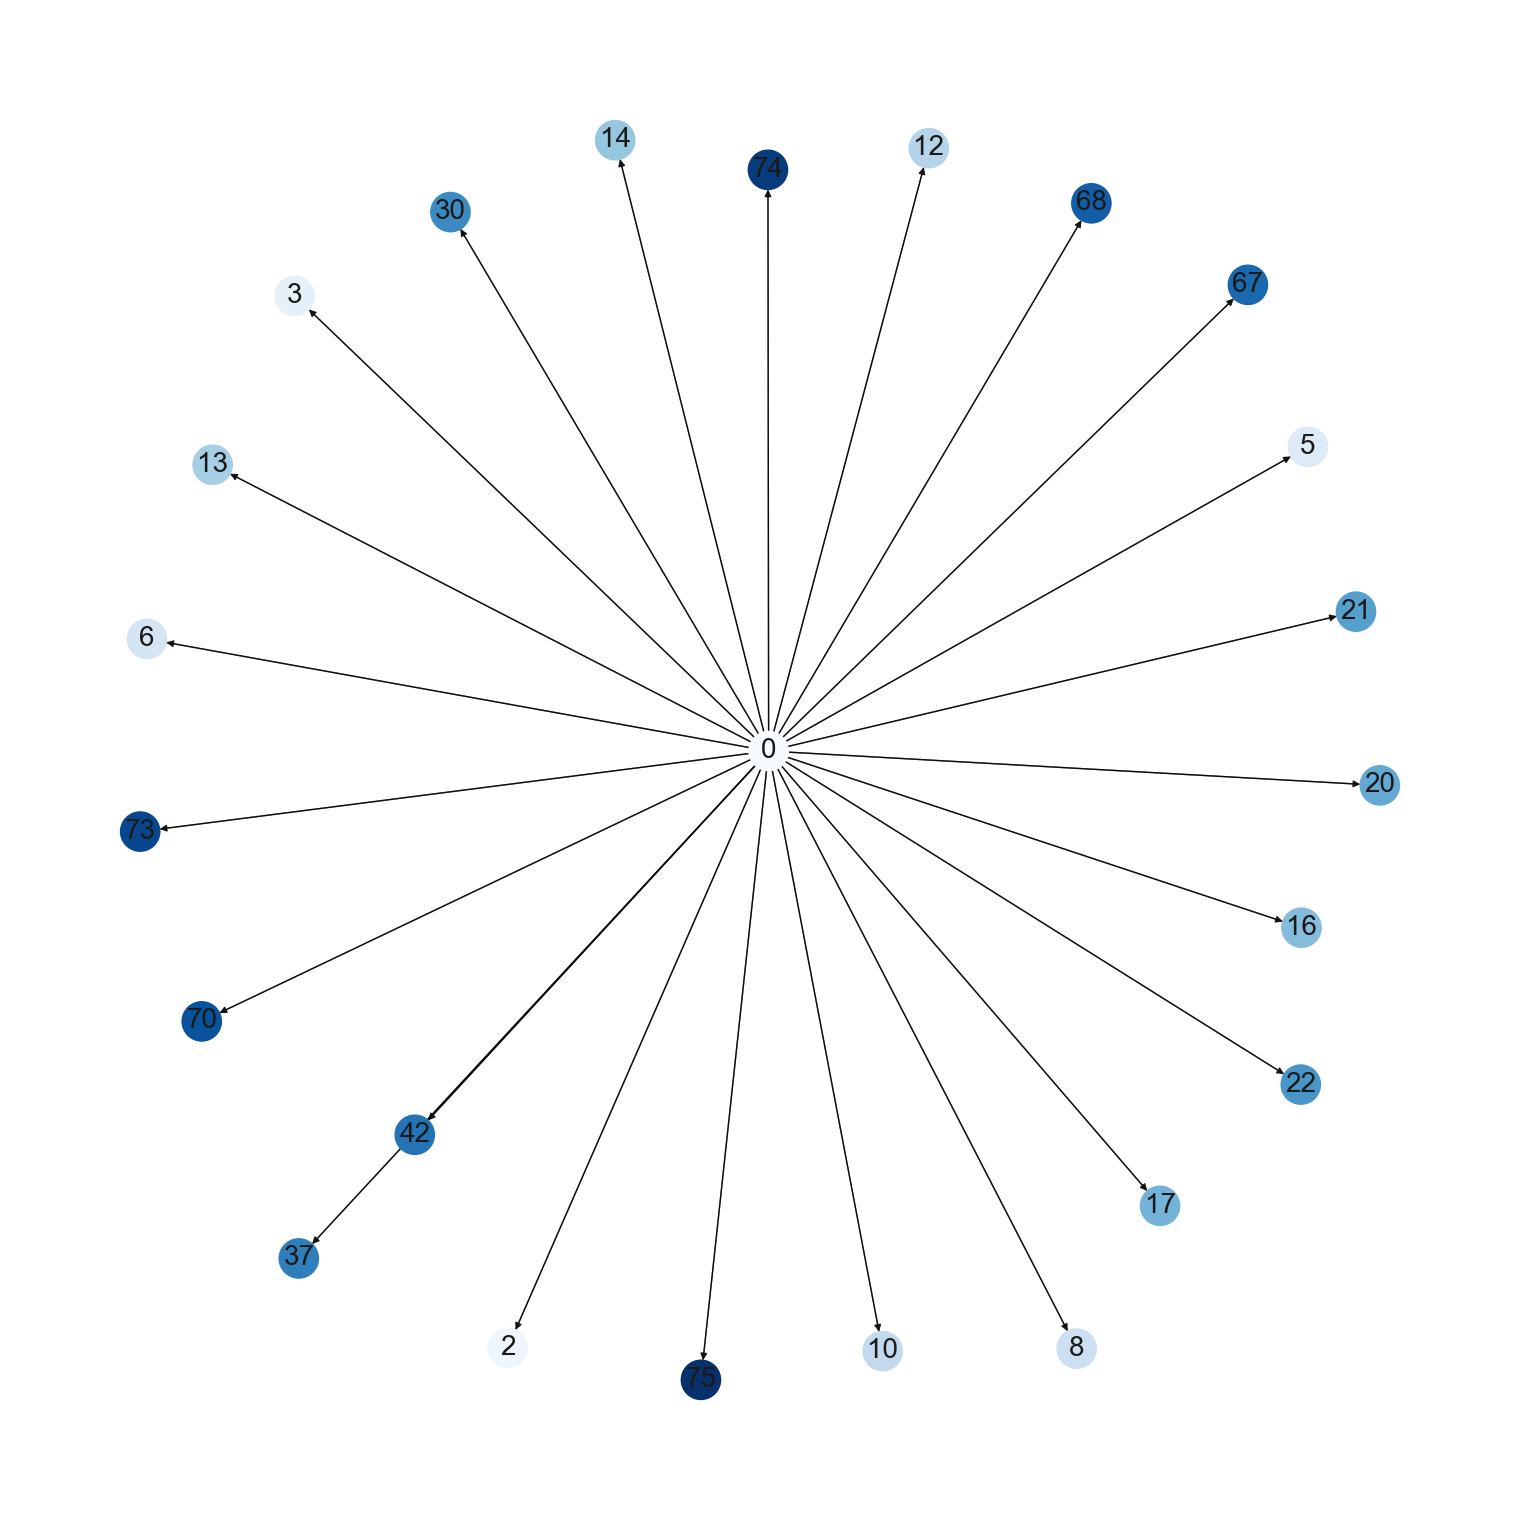

In [24]:
bfs_graph_24 = nx.bfs_tree(G_24, 0)
pos = nx.spring_layout(bfs_graph_24, seed=76)
nx.draw(bfs_graph_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    bfs_graph_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(bfs_graph_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(bfs_graph_24, "weight")
nx.draw_networkx_edge_labels(bfs_graph_24, pos, edge_labels)

plt.show()

### Algoritmo de Prim

Dado que nuestro objetivo es trazar rutas y conocer las distancias entre los circuitos, un algoritmo que nos será de utilidad será el algoritmo de prim cuyo objetivo es encontrar un árbol generador mínimo en una gráfica conexa, no dirigida y cuyas aristas están ponderadas.   

Este es un algoritmo que encuentra un subconjunto de aristas que forman un árbol con todos los vértices, donde el peso total de todas las aristas en el árbol es el mínimo posible.   

La complejidad de este algoritmo depende de la estructura en la que $G$ esté implementada, de estar en una matriz de adyacencias su complejidad será de $O(|V|^2)$, no obstante si tenemos que $G$ se almacena en un Fibonacci Heap, entonces su complejidad se reduce a $O(|E| + |V|\log |V|)$.

```
func prim(G):
    v0=algun vértice de T
    T=[v0]
    A=V(G)\{v0}
    aristas_buenas=[]
    mientras A no sea vacío:
        elegir la arista uv de menor peso con u en T y v en A
        agregar uv a aristas_buenas
        pasar v de A a T
    regresar aristas_buenas
```

#### Gráfica 76 Circuitos

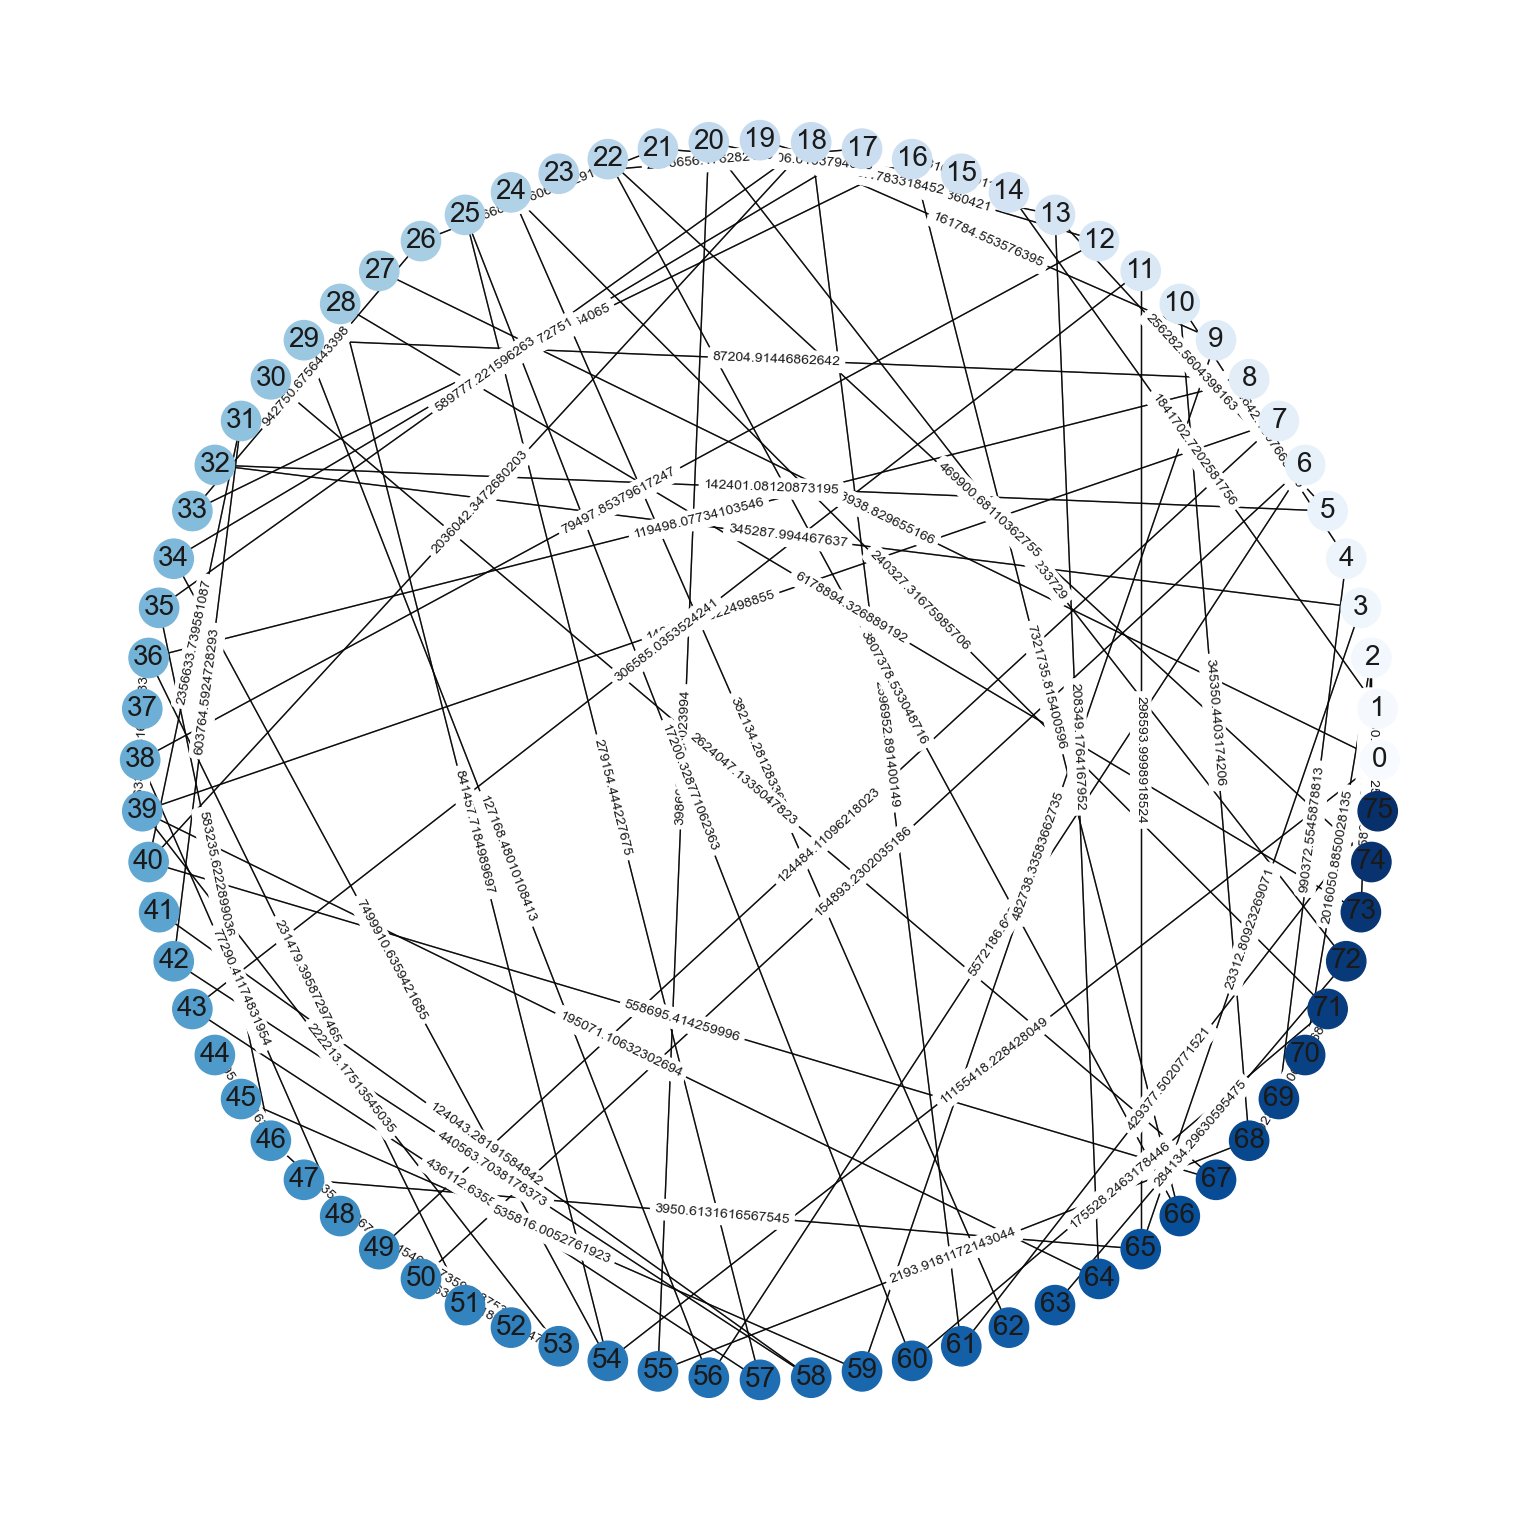

In [25]:
minimum_prim_tree = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')
pos = nx.circular_layout(minimum_prim_tree)
nx.draw(minimum_prim_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_prim_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_prim_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_prim_tree, "weight")
nx.draw_networkx_edge_labels(minimum_prim_tree, pos, edge_labels)

plt.show()

#### Gráfica 24 Circuitos

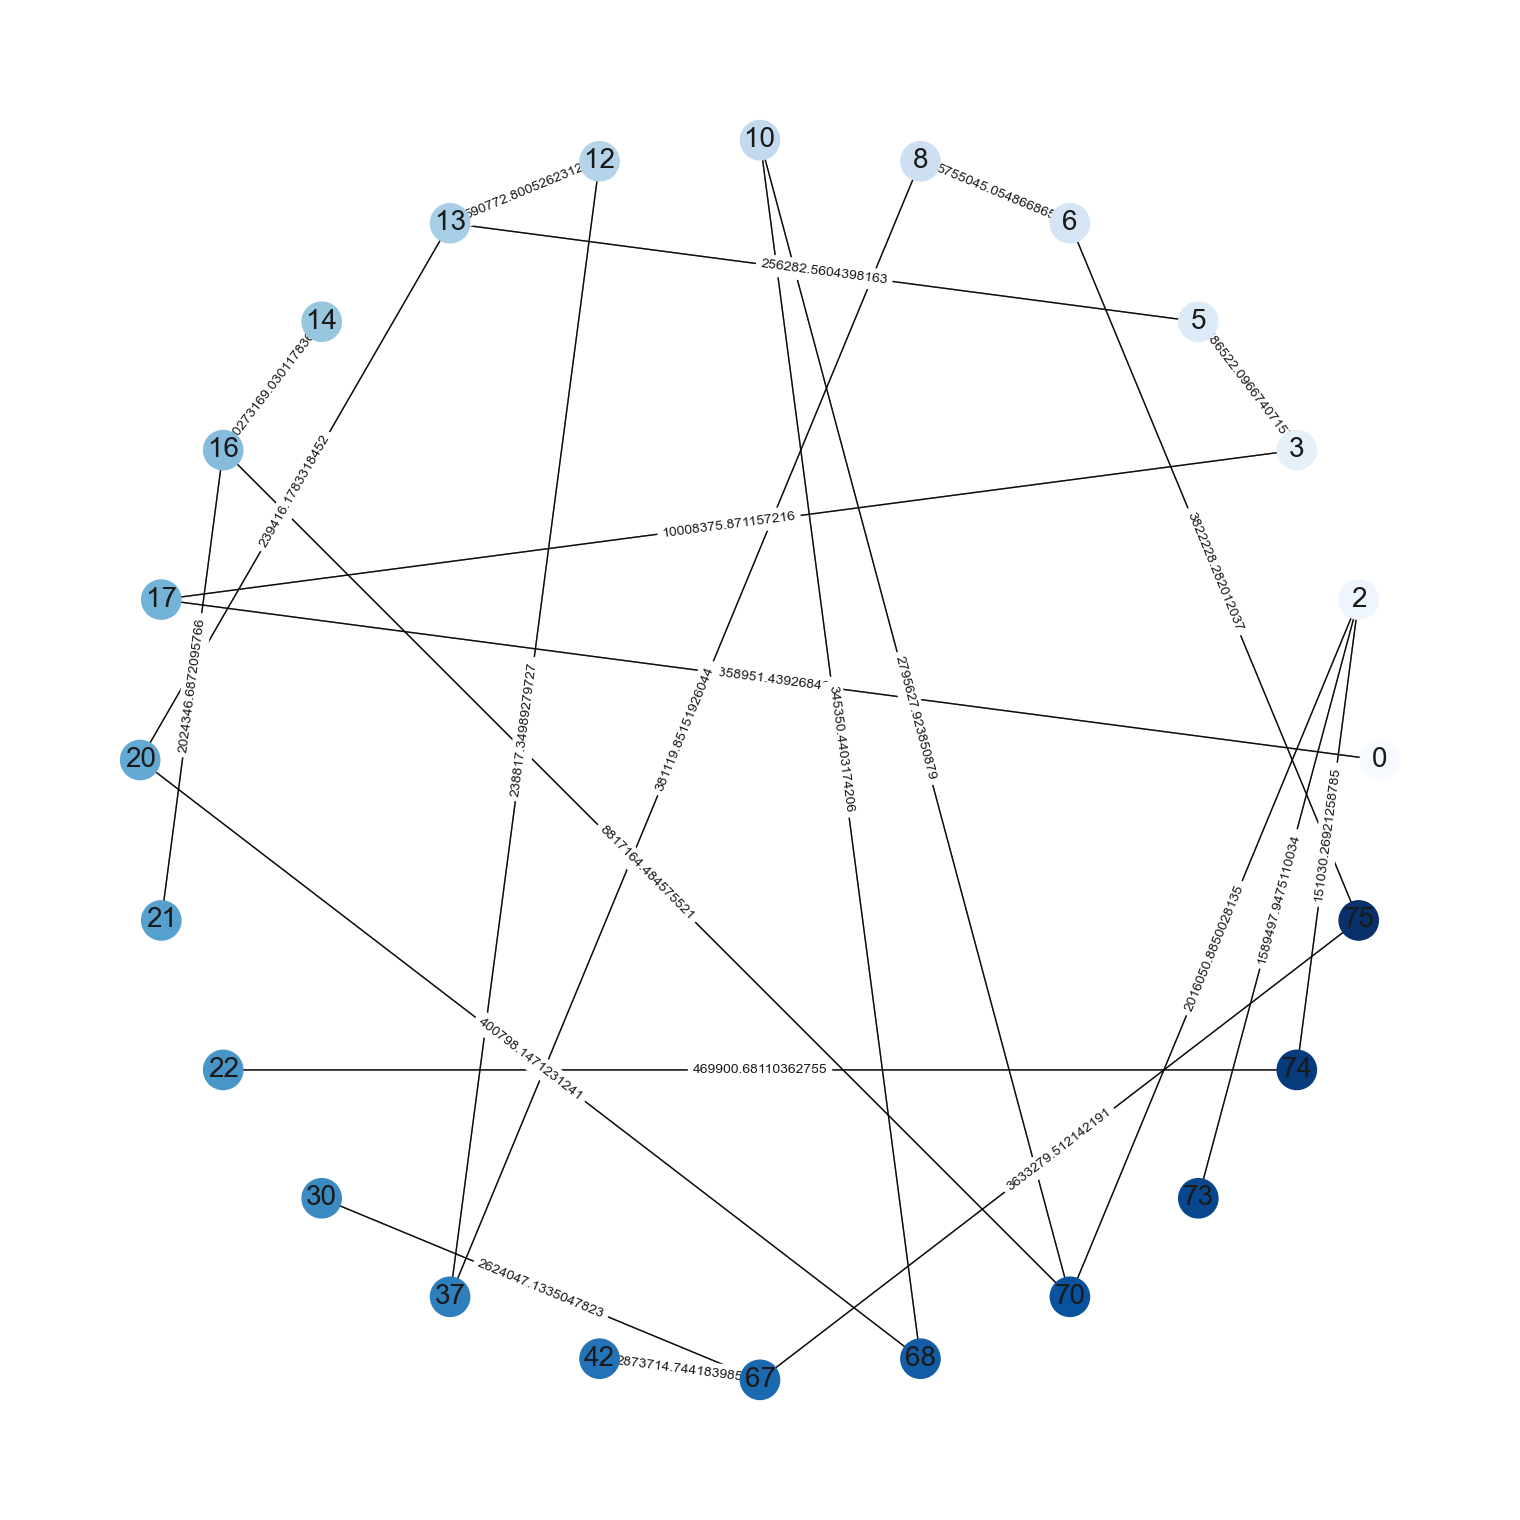

In [26]:
minimum_prim_tree_24 = nx.minimum_spanning_tree(G_24, algorithm='prim', weight='weight')
pos = nx.circular_layout(minimum_prim_tree_24)
nx.draw(minimum_prim_tree_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_prim_tree_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_prim_tree_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_prim_tree_24, "weight")
nx.draw_networkx_edge_labels(minimum_prim_tree_24, pos, edge_labels)

plt.show()

### Algoritmo Kruskal

El algoritmo de Kruskal es un algoritmo que sirve para encontrar un árbol generador mínimo en una gráfica conexa y ponderada. Es un ejemplo de algoritmo voraz cuya complejidad en estructuras de datos simples y realizando DFS tendríamos un tiempo de $O(m\log m + m(m+n))$ pasos, lo cual es demasiado. No obstante este tiempo se mejora usando una estructura de datos para conjuntos disjuntos (**disjoint-set data structure**) y así poder controlar qué vértices están en qué componentes. Es necesario hacer orden de O(m) operaciones ya que por cada arista hay dos operaciones de búsqueda y posiblemente una unión de conjuntos. Incluso una estructura de datos sobre conjuntos disjuntos simple con uniones por rangos puede ejecutar las operaciones mencionadas en O(m log n). Por tanto, la complejidad total es del orden de $O(m \log m) = O(m \log n)$.   

Pseudocódigo:

```
func kruskal(G):
    L=aristas de G
    ordenar L por peso
    T=[]
    para cada arista e en L:
        si podemos agregar e a T sin formar ciclos:
            lo hacemos y aumentamos k en 1
        si T tiene n-1 aristas:
            regresamos T
```

#### Gráfica 76 Circuitos

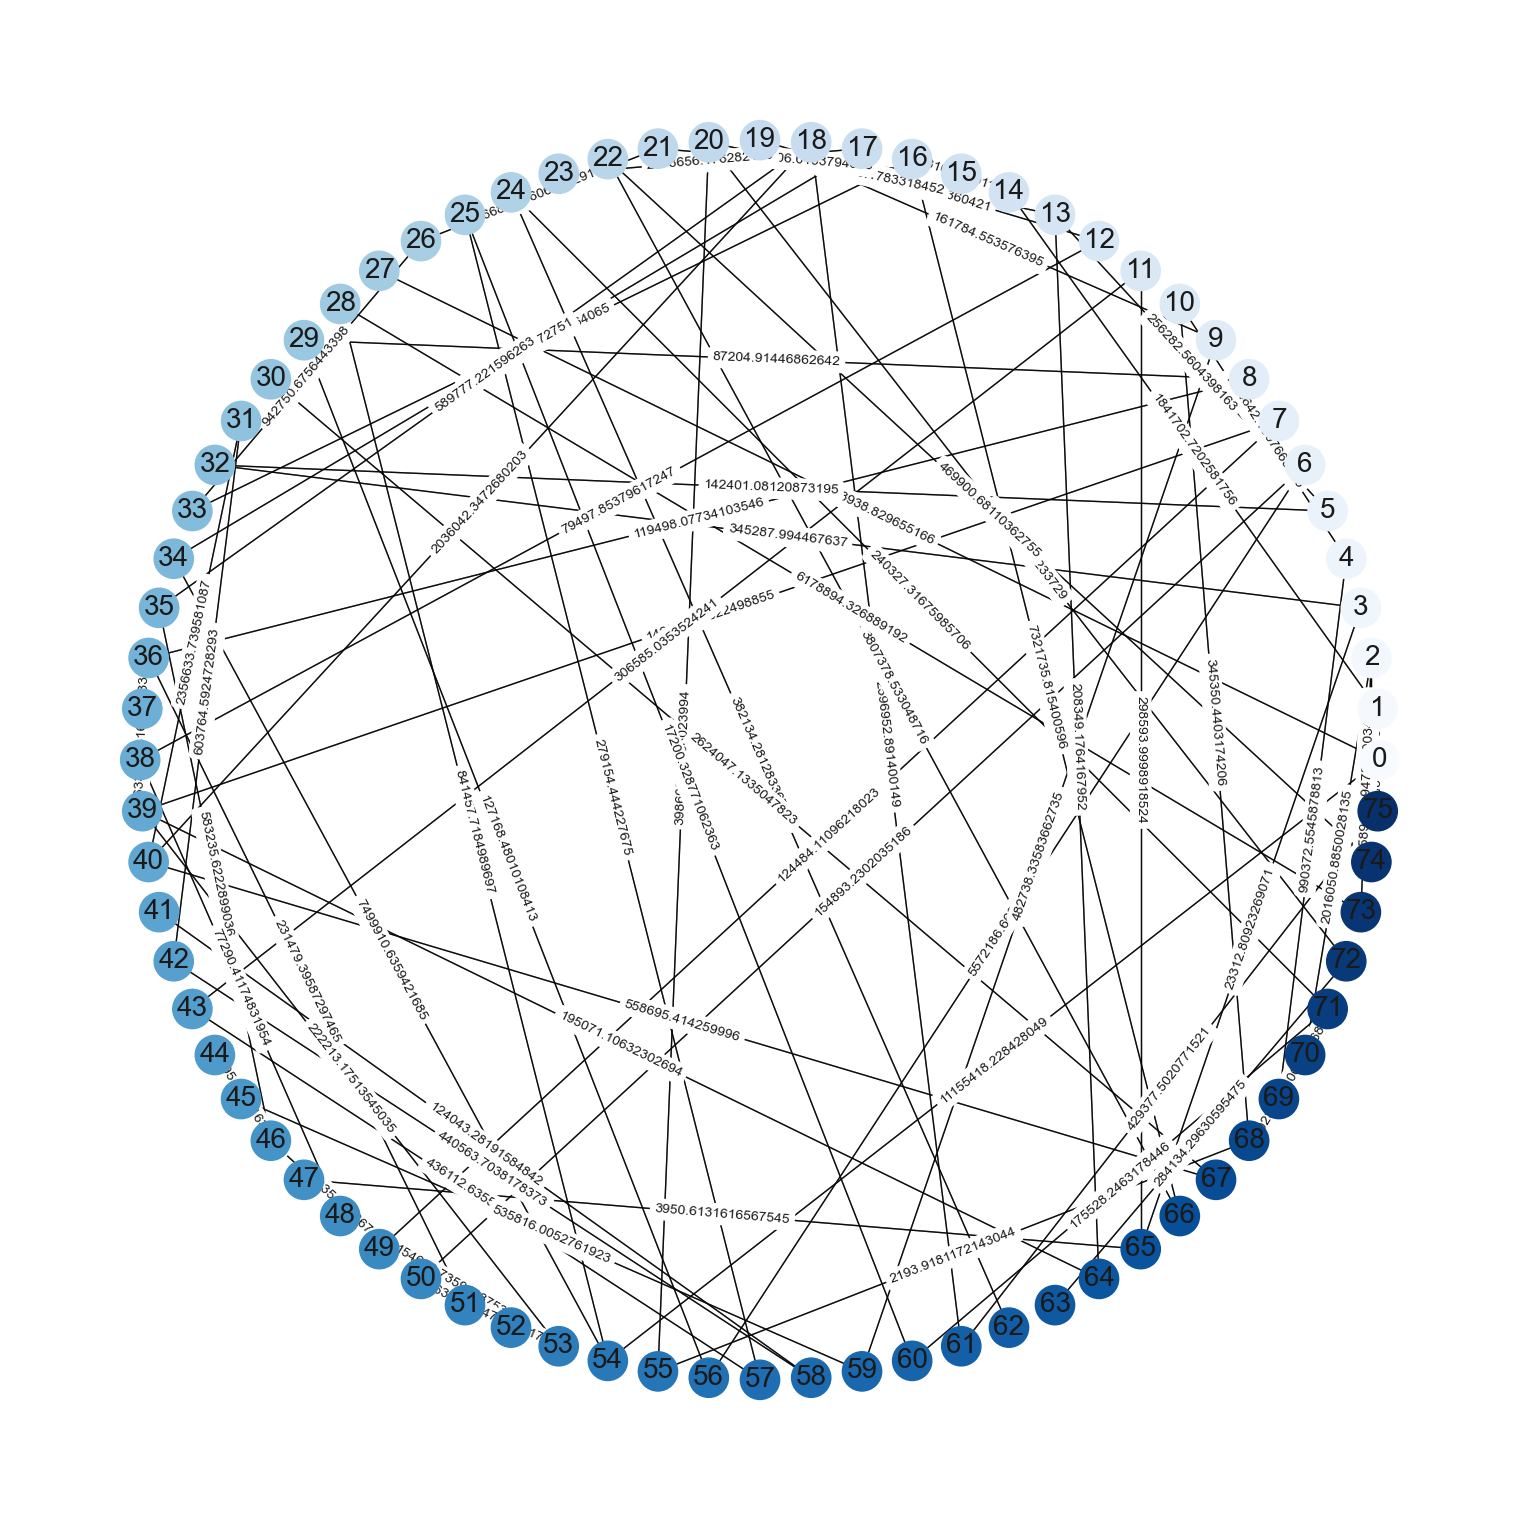

In [27]:
minimum_kruskal_tree = nx.minimum_spanning_tree(G, algorithm='kruskal', weight='weight')
pos = nx.circular_layout(minimum_kruskal_tree)
nx.draw(minimum_kruskal_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_kruskal_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_kruskal_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_kruskal_tree, "weight")
nx.draw_networkx_edge_labels(minimum_kruskal_tree, pos, edge_labels)

plt.show()

#### Gráfica 24 Circuitos

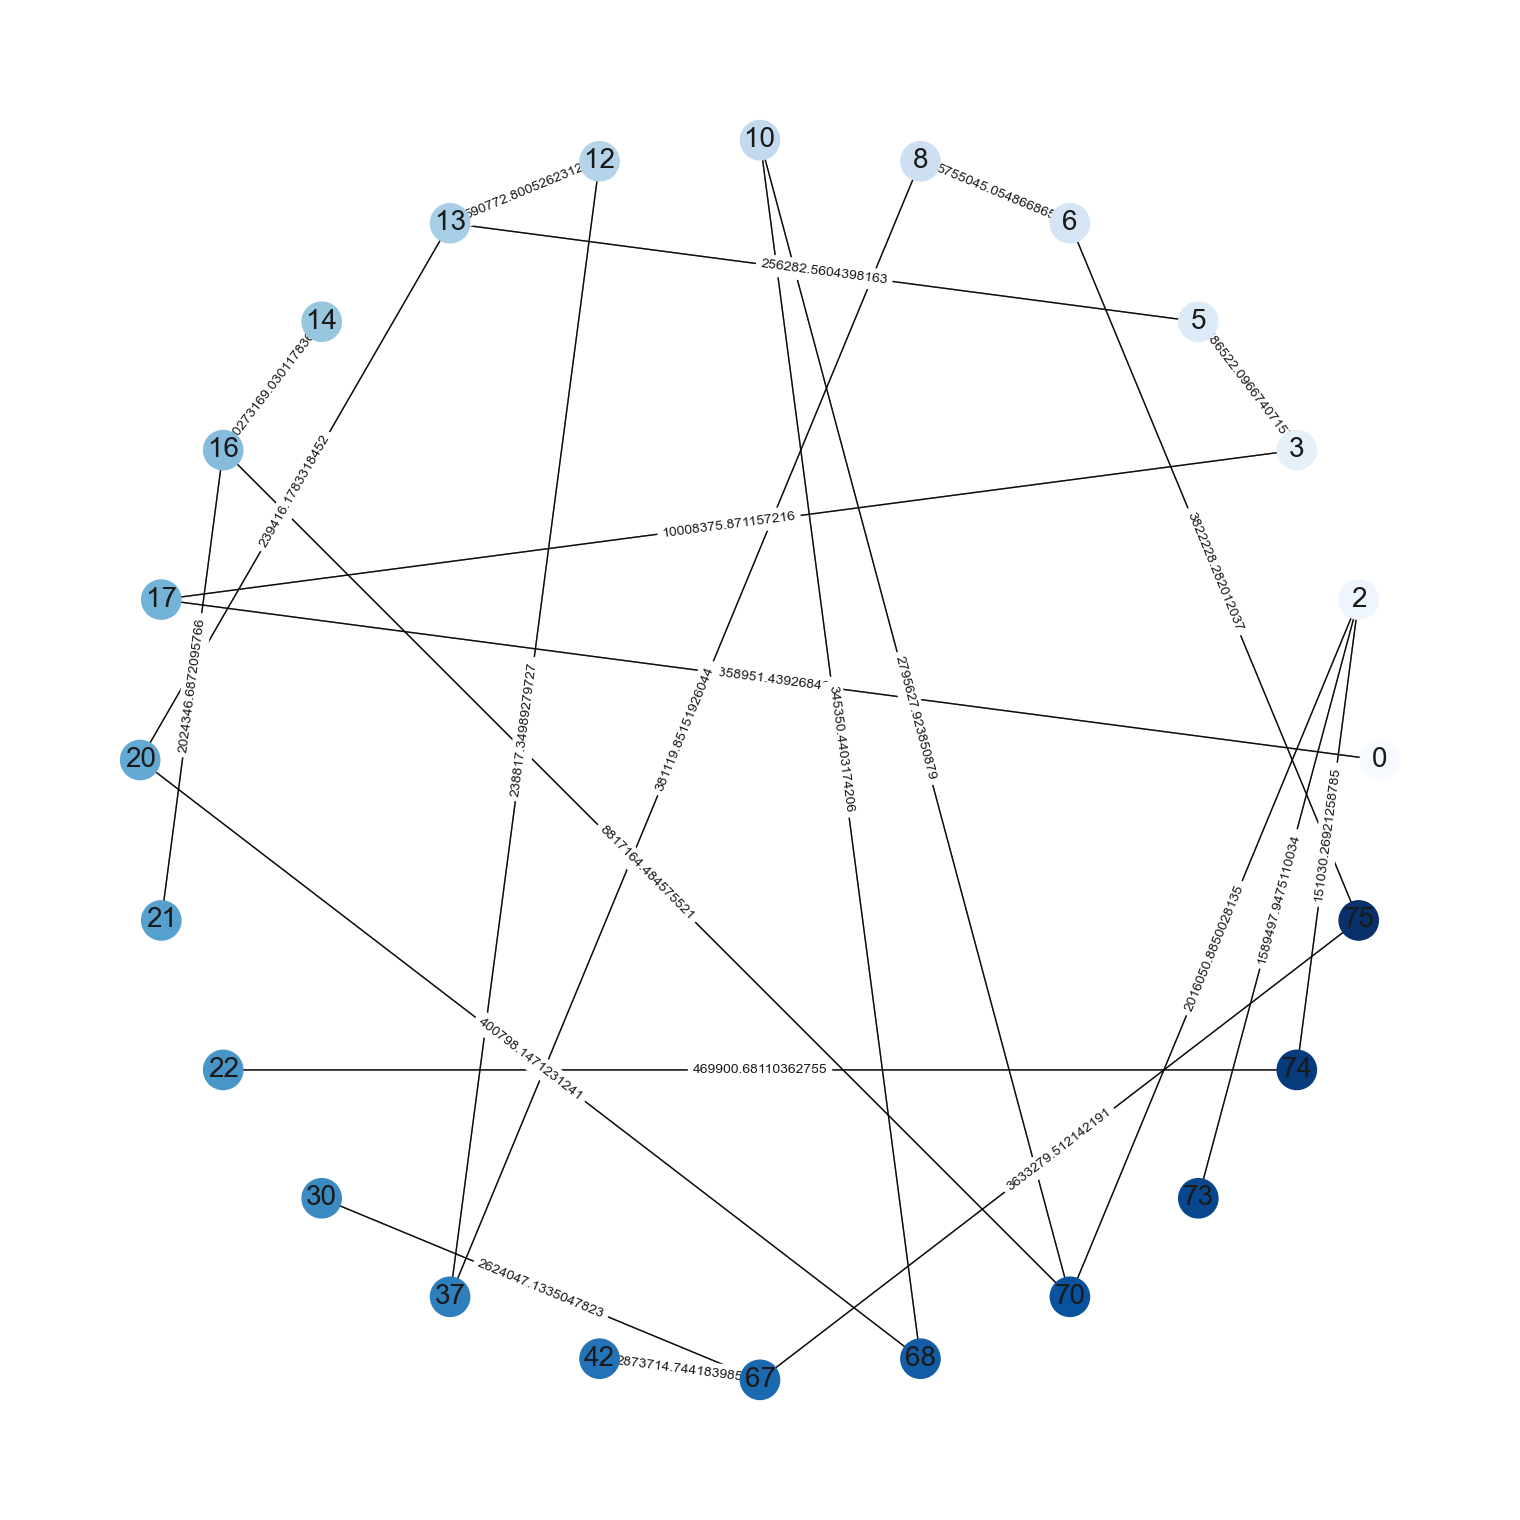

In [28]:
minimum_kruskal_tree_24 = nx.minimum_spanning_tree(G_24, algorithm='kruskal', weight='weight')
pos = nx.circular_layout(minimum_kruskal_tree_24)
nx.draw(minimum_kruskal_tree_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_kruskal_tree_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_kruskal_tree_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_kruskal_tree_24, "weight")
nx.draw_networkx_edge_labels(minimum_kruskal_tree_24, pos, edge_labels)

plt.show()

### Algoritmo Boruvka

El algoritmo de Borůvka es un algoritmo que sirve para encontrar el árbol generador mínimo en una gráfica ponderado en el que todas sus aristas tienen distinto peso. Este algoritmo puede llegar a obtener una complejidad de $O(|E|\log |V|)$. En una gráfica plana puede implementarse para ejecutarse en tiempo lineal, eliminando aristas de menor peso entre cada par de nodos después de cada etapa del algoritmo.   

**Algoritmo**   

El algoritmo comienza examinando cada vértice y añadiendo la arista de menor peso desde ese vértice a otro en la gráfica, sin tener en cuenta las aristas ya agregadas, y continua uniendo estos grupos de la misma manera hasta que se completa un árbol que cubra todos los vértices. Si denominamos a cada vértice o conjunto de vértices conectados como una *componente*, el pseudocódigo del Algoritmo de Boruvka es:   

```
1. Comenzamos con una gráfica conexa G en el que todas sus aristas tengan distinto peso, y un conjunto vacío de aristas T.
2. Mientras los vértices de G conectados por T sean disjuntos:
3.    Crear un conjunto vacío de aristas S
4.    Para cada componente:
5.        Crear un conjunto vacío de aristas S
6.        Para cada vértice v en el componente:
7.            Agregar la arista de menor peso desde el vértice v a otro vértice en un componente disjunto a S
8.        Añadir la arista de menor peso en S a E
9.    Añadir el conjunto resultante E a T.
10. El conjunto de aristas resultante T es el árbol generador mínimo de G.
```



#### Gráfica 76 Circuitos

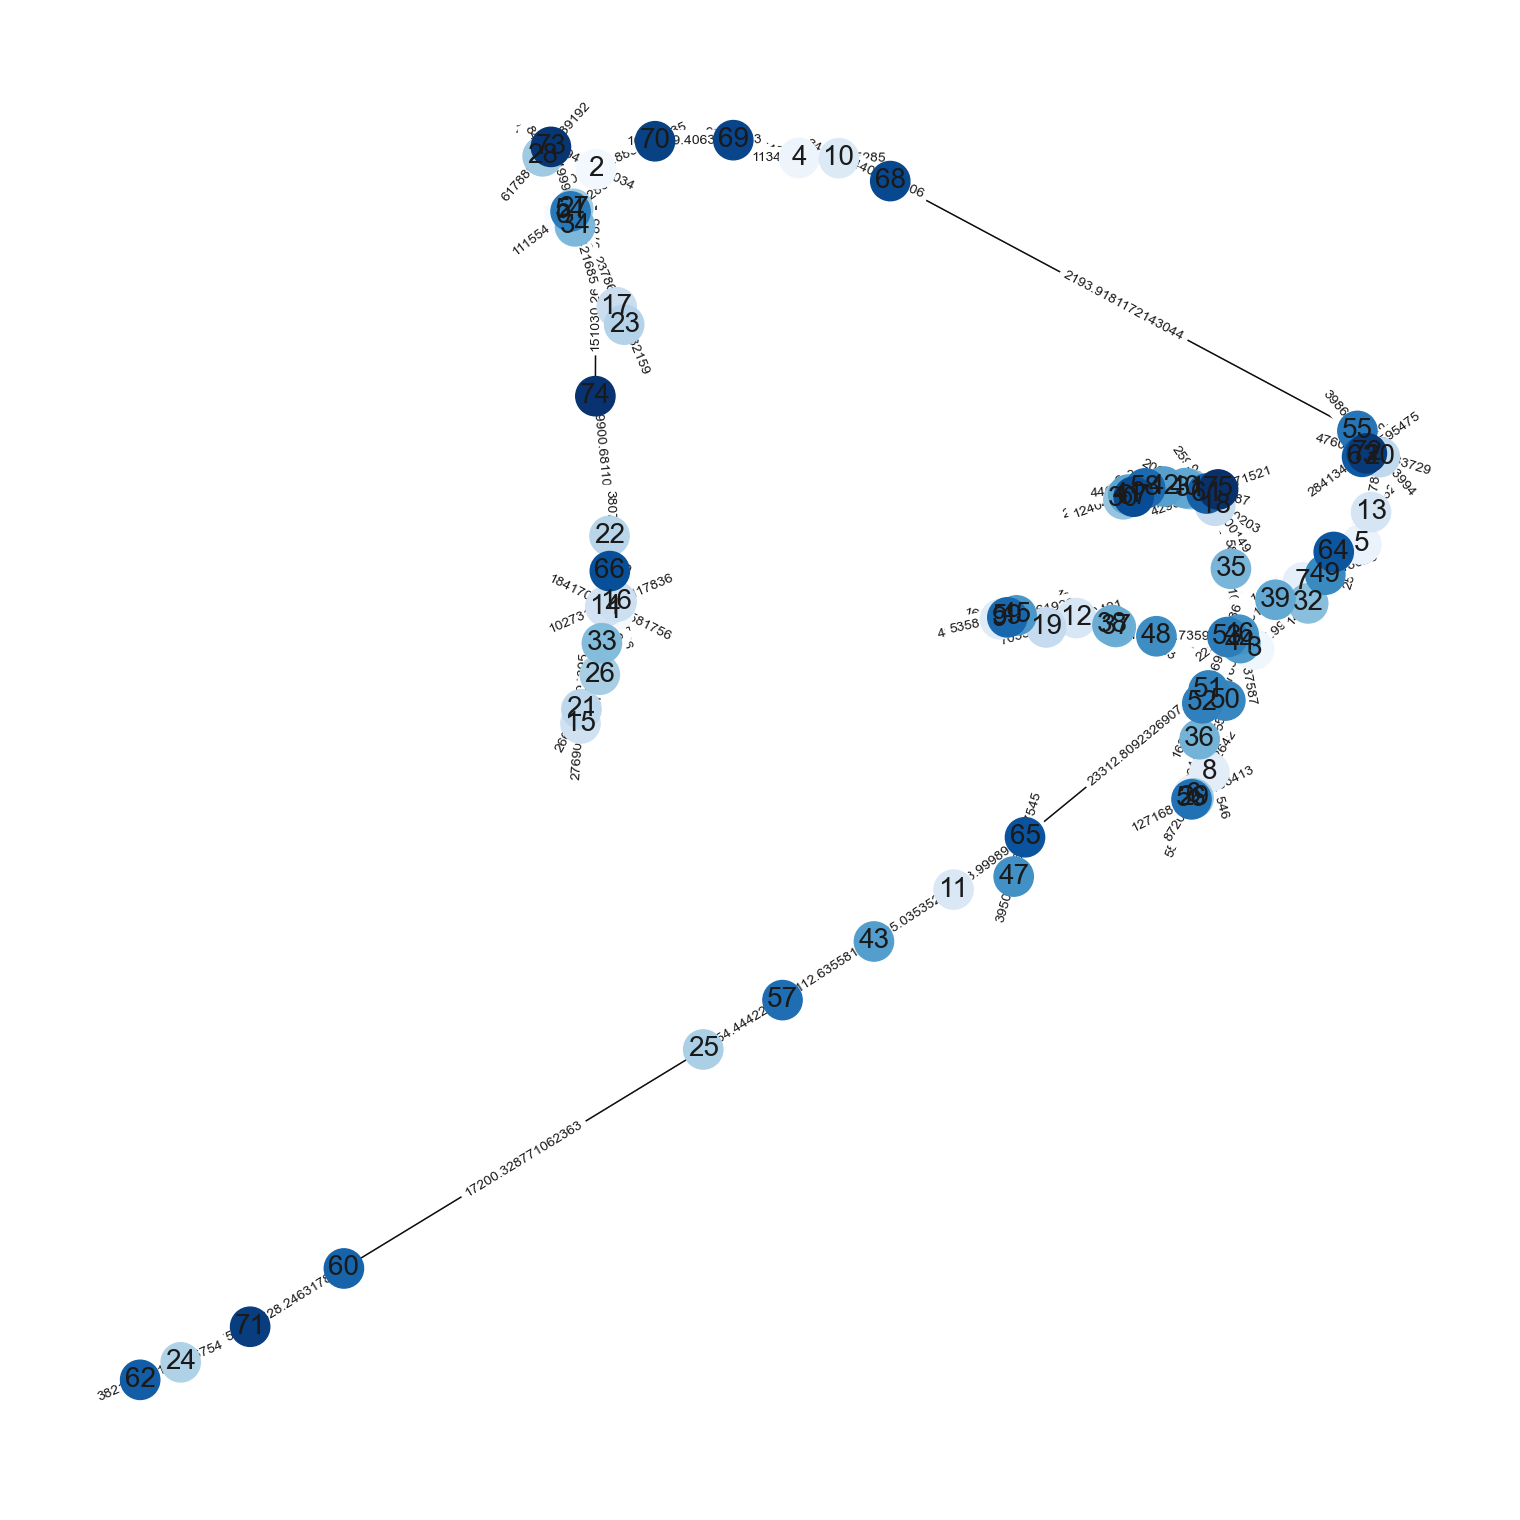

In [29]:
minimum_boruvka_tree = nx.minimum_spanning_tree(G, algorithm='boruvka', weight='weight')
pos = nx.spring_layout(minimum_boruvka_tree, seed=76)
nx.draw(minimum_boruvka_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_boruvka_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_boruvka_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_boruvka_tree, "weight")
nx.draw_networkx_edge_labels(minimum_boruvka_tree, pos, edge_labels)

plt.show()

#### Gráfica 24 Circuitos

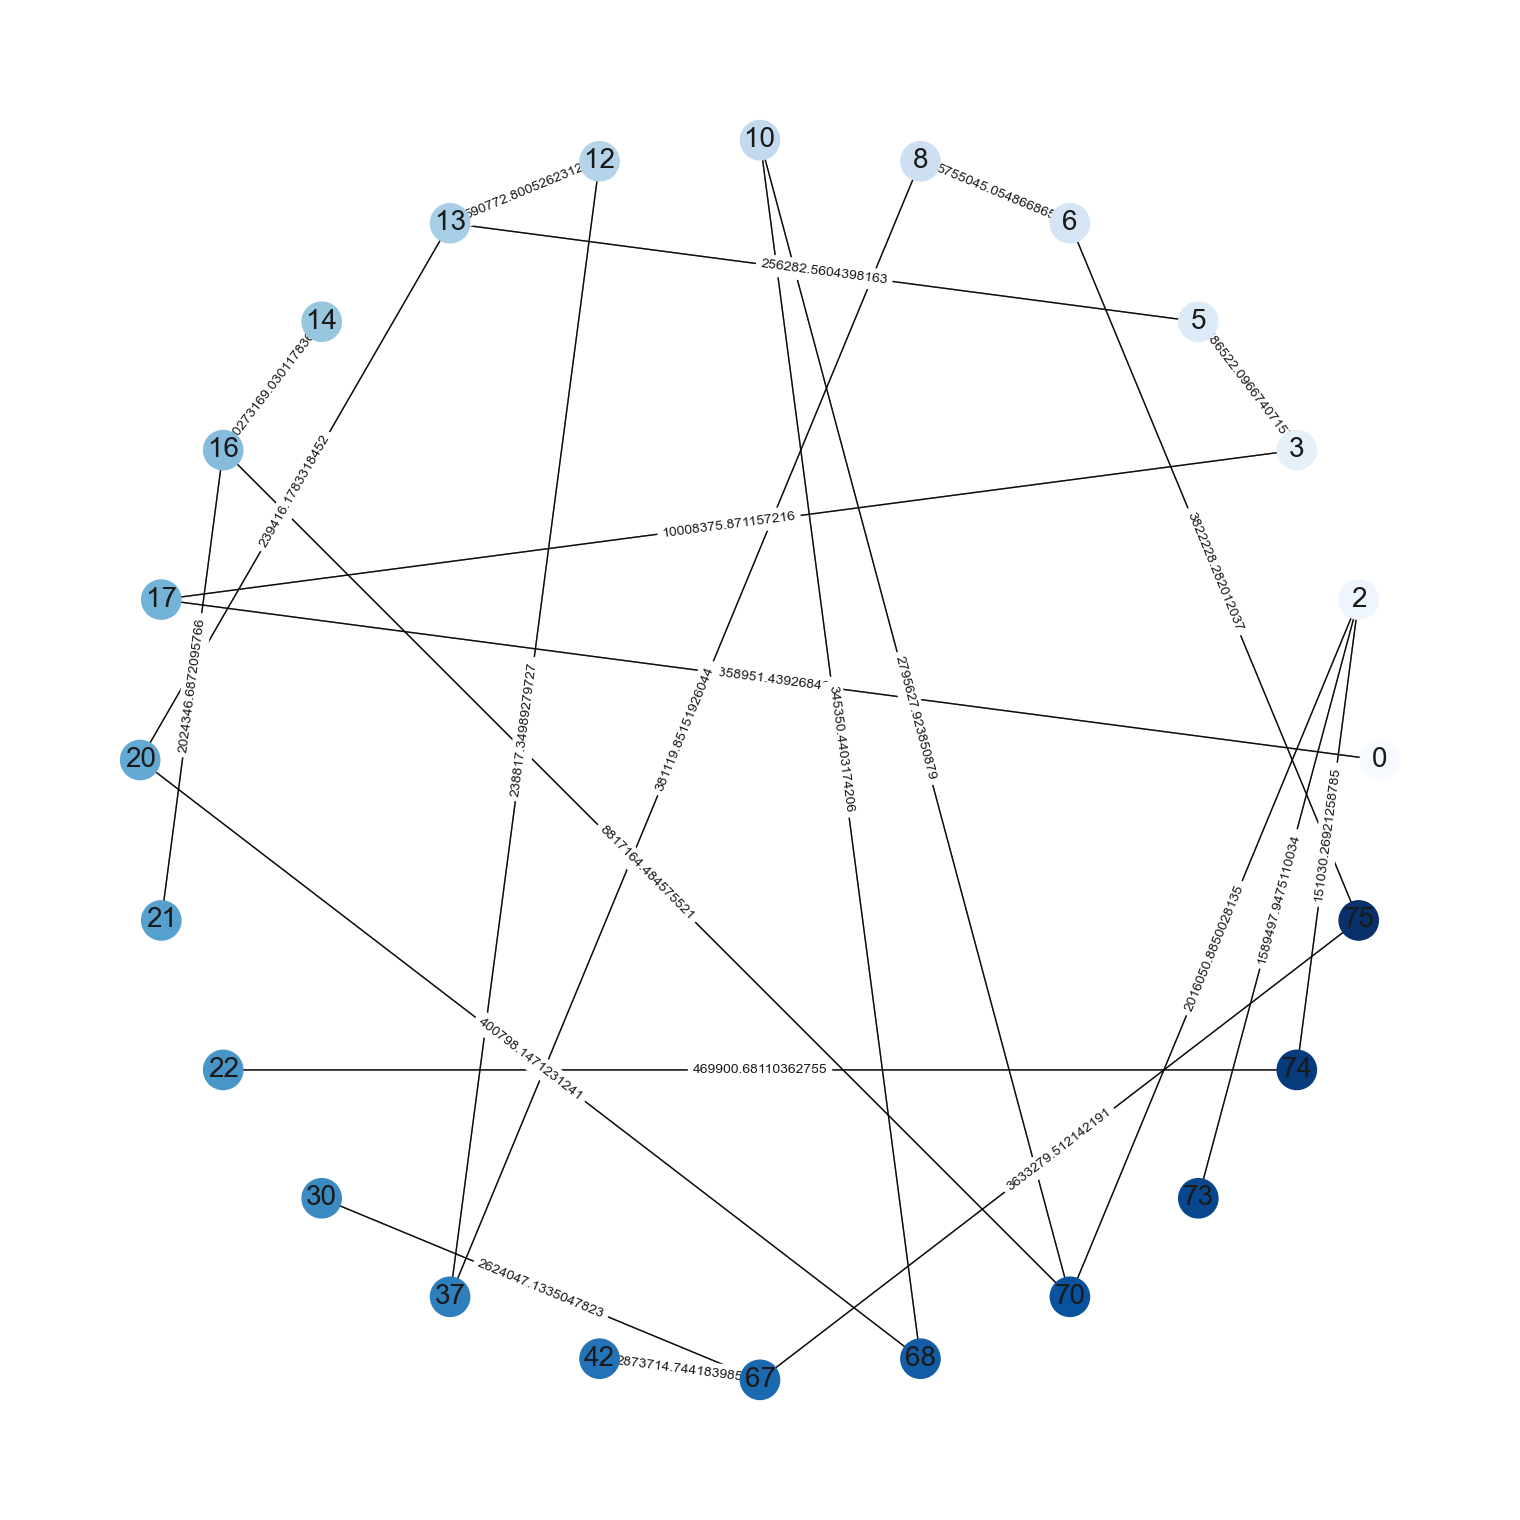

In [30]:
minimum_boruvka_tree_24 = nx.minimum_spanning_tree(G_24, algorithm='kruskal', weight='weight')
pos = nx.circular_layout(minimum_boruvka_tree_24)
nx.draw(minimum_boruvka_tree_24, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_boruvka_tree_24, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_boruvka_tree_24, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_boruvka_tree_24, "weight")
nx.draw_networkx_edge_labels(minimum_boruvka_tree_24, pos, edge_labels)

plt.show()

### Ruta con el árbol generador mínimo

#### 76 Circuitos

Recorremos el árbol generador mínimo usando DFS para obtener una posible ruta que podemos seguir iniciando nuestro viaje por Bahrein, no obstante aplicando ya sea DFS o BFS el resultado de las aristas que sigue el algoritmo siempre resulta en que regresa al vértice padre y vuelve a verificar, por lo que esta ruta no sería la optima para minimizar el recorrido y por tanto los gastos.

In [31]:
inverse_dict_circuits['Bahrain International Circuit']

2

In [32]:
lst = list(nx.dfs_edges(minimum_boruvka_tree, source=2))

In [33]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for c1, c2 in lst:
    if counter != 0:
        print(f'y posteriormente de {dict_circuits[c1]} iremos a {dict_circuits[c2]}')
        print('recorriendo una cantidad de : {:.3f} km'.format(minimum_boruvka_tree.get_edge_data(c1,c2)['weight']/1000))
    else:
        print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
        print('recorriendo una cantidad de : {:.3f} km'.format(minimum_boruvka_tree.get_edge_data(c1,c2)['weight']/1000))
        counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Bahrain International Circuit y posteriormente iremos al Losail International Circuit
recorriendo una cantidad de : 151.030 km
y posteriormente de Losail International Circuit iremos a Yas Marina Circuit
recorriendo una cantidad de : 469.901 km
y posteriormente de Yas Marina Circuit iremos a Buddh International Circuit
recorriendo una cantidad de : 3807.379 km
y posteriormente de Buddh International Circuit iremos a Shanghai International Circuit
recorriendo una cantidad de : 7321.736 km
y posteriormente de Shanghai International Circuit iremos a Korean International Circuit
recorriendo una cantidad de : 886.027 km
y posteriormente de Korean International Circuit iremos a Okayama International Circuit
recorriendo una cantidad de : 942.751 km
y posteriormente de Okayama International Circuit iremos a Suzuka Circuit
recorriendo una cantidad de : 266.861 km
y

y así hemos recorrido los 76 circuitos de una manera en la que minimizamos el recorrido y por tanto también el gasto en transportación.

#### 24 Circuitos

De igual forma recorremos el árbol generador mínimo usando DFS para obtener una posible ruta que podemos seguir iniciando nuestro viaje por Bahrein. Además tampoco resulta en que la ruta regresada sea aquella ruta optima que minimiza el recorrido y por tanto los costos.

In [34]:
lst_24 = list(nx.dfs_edges(minimum_boruvka_tree_24, source=2))

In [35]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for c1, c2 in lst_24:
    if counter != 0:
        print(f'y posteriormente de {dict_circuits[c1]} iremos a {dict_circuits[c2]}')
        print('recorriendo una cantidad de : {:.3f} km'.format(minimum_boruvka_tree_24.get_edge_data(c1,c2)['weight']/1000))
    else:
        print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
        print('recorriendo una cantidad de : {:.3f} km'.format(minimum_boruvka_tree_24.get_edge_data(c1,c2)['weight']/1000))
        counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Bahrain International Circuit y posteriormente iremos al Losail International Circuit
recorriendo una cantidad de : 151.030 km
y posteriormente de Losail International Circuit iremos a Yas Marina Circuit
recorriendo una cantidad de : 469.901 km
y posteriormente de Bahrain International Circuit iremos a Jeddah Corniche Circuit
recorriendo una cantidad de : 1589.498 km
y posteriormente de Bahrain International Circuit iremos a Baku City Circuit
recorriendo una cantidad de : 2016.051 km
y posteriormente de Baku City Circuit iremos a Hungaroring
recorriendo una cantidad de : 2795.628 km
y posteriormente de Hungaroring iremos a Red Bull Ring
recorriendo una cantidad de : 345.350 km
y posteriormente de Red Bull Ring iremos a Autodromo Enzo e Dino Ferrari
recorriendo una cantidad de : 400.798 km
y posteriormente de Autodromo Enzo e Dino Ferrari iremos a Autodromo

### Travelling Salesman Problem (TSP)

El objetivo de este algoritmo es encontrar un recorrido completo que conecte todos los nodos de una red, visitándolos tan solo una vez y volviendo al punto de partida, y que además minimice la distancia total de la ruta, o el tiempo total del recorrido.

TSP tiene una variación importante, y esta depende de que las distancias entre un nodo y otro sean simétricas o no, es decir, que la distancia entre A y B sea igual a la distancia entre B y A, puesto que en la práctica es muy poco probable que así sea. En nuestro caso suponemos que las distancias si son simétricas.

Ahora la cantidad de rutas posibles en una red está determinada por 

$$
(n-1)!
$$

siendo $n$ la cantidad de nodos.

#### Gráfica 76 Circuitos

Calculamos una aproximación utilizando el algoritmo de NetworkX que resuleve TSP

In [36]:
TSP = nx.approximation.greedy_tsp(G, source=2)

In [37]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for i in range(len(TSP)):
    if i != len(TSP)-1:
        c1 = TSP[i]
        c2 = TSP[i+1]
        dist = G.get_edge_data(c1,c2)['weight']/1000
        if counter != 0:
            print(f'y posteriormente seguimos desde {dict_circuits[c1]} hacia el {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
        else:
            print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
            counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Bahrain International Circuit y posteriormente iremos al Losail International Circuit
recorriendo una cantidad de : 151.030 km
y posteriormente seguimos desde Losail International Circuit hacia el Yas Marina Circuit
recorriendo una cantidad de : 469.901 km
y posteriormente seguimos desde Yas Marina Circuit hacia el Jeddah Corniche Circuit
recorriendo una cantidad de : 2105.592 km
y posteriormente seguimos desde Jeddah Corniche Circuit hacia el Istanbul Park
recorriendo una cantidad de : 2612.236 km
y posteriormente seguimos desde Istanbul Park hacia el Sochi Autodrom
recorriendo una cantidad de : 990.373 km
y posteriormente seguimos desde Sochi Autodrom hacia el Baku City Circuit
recorriendo una cantidad de : 1023.689 km
y posteriormente seguimos desde Baku City Circuit hacia el Hungaroring
recorriendo una cantidad de : 2795.628 km
y posteriormente seguimo

Calculamos una aproximación utilizando el algoritmo de NetworkX que resuelve TSP y con la condición que sea un camino y no un ciclo.

In [38]:
tsp = nx.approximation.traveling_salesman_problem(G, cycle=False)

In [39]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for i in range(len(tsp)):
    if i != len(tsp)-1:
        c1 = tsp[i]
        c2 = tsp[i+1]
        dist = G.get_edge_data(c1,c2)['weight']/1000
        if counter != 0:
            print(f'y posteriormente seguimos desde {dict_circuits[c1]} hacia el {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
        else:
            print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
            counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Buddh International Circuit y posteriormente iremos al Yas Marina Circuit
recorriendo una cantidad de : 3807.379 km
y posteriormente seguimos desde Yas Marina Circuit hacia el Losail International Circuit
recorriendo una cantidad de : 469.901 km
y posteriormente seguimos desde Losail International Circuit hacia el Jeddah Corniche Circuit
recorriendo una cantidad de : 1691.525 km
y posteriormente seguimos desde Jeddah Corniche Circuit hacia el Kyalami
recorriendo una cantidad de : 6178.894 km
y posteriormente seguimos desde Kyalami hacia el Autódromo Internacional Nelson Piquet
recorriendo una cantidad de : 7704.360 km
y posteriormente seguimos desde Autódromo Internacional Nelson Piquet hacia el Autódromo José Carlos Pace
recorriendo una cantidad de : 476.166 km
y posteriormente seguimos desde Autódromo José Carlos Pace hacia el Autódromo Juan y Oscar Gálv

#### Gráfica 24 Circuitos

Calculamos una aproximación utilizando el algoritmo de NetworkX que resuleve TSP

In [40]:
TSP_24 = nx.approximation.greedy_tsp(G_24)

In [41]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for i in range(len(TSP_24)):
    if i != len(TSP_24)-1:
        c1 = TSP_24[i]
        c2 = TSP_24[i+1]
        dist = G_24.get_edge_data(c1,c2)['weight']/1000
        if counter != 0:
            print(f'y posteriormente seguimos desde {dict_circuits[c1]} hacia el {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
        else:
            print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
            counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Albert Park Grand Prix Circuit y posteriormente iremos al Autódromo José Carlos Pace
recorriendo una cantidad de : 14358.951 km
y posteriormente seguimos desde Autódromo José Carlos Pace hacia el Circuit de Barcelona-Catalunya
recorriendo una cantidad de : 10008.376 km
y posteriormente seguimos desde Circuit de Barcelona-Catalunya hacia el Circuit de Monaco
recorriendo una cantidad de : 486.522 km
y posteriormente seguimos desde Circuit de Monaco hacia el Autodromo Nazionale di Monza
recorriendo una cantidad de : 256.283 km
y posteriormente seguimos desde Autodromo Nazionale di Monza hacia el Autodromo Enzo e Dino Ferrari
recorriendo una cantidad de : 239.416 km
y posteriormente seguimos desde Autodromo Enzo e Dino Ferrari hacia el Red Bull Ring
recorriendo una cantidad de : 400.798 km
y posteriormente seguimos desde Red Bull Ring hacia el Hungaroring
reco

In [42]:
tsp_24 = nx.approximation.traveling_salesman_problem(G_24, cycle=False)

In [43]:
print('----------------------- ')
print('     RUTA FÓRMULA 1     ')
print('----------------------- ')
print(' - Iniciamos el viaje - ')
counter = 0
for i in range(len(tsp_24)):
    if i != len(tsp_24)-1:
        c1 = tsp_24[i]
        c2 = tsp_24[i+1]
        dist = G_24.get_edge_data(c1,c2)['weight']/1000
        if counter != 0:
            print(f'y posteriormente seguimos desde {dict_circuits[c1]} hacia el {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
        else:
            print(f'Iniciaremos nuestro viaje en el {dict_circuits[c1]} y posteriormente iremos al {dict_circuits[c2]}')
            print('recorriendo una cantidad de : {:.3f} km'.format(dist))
            counter += 1

----------------------- 
     RUTA FÓRMULA 1     
----------------------- 
 - Iniciamos el viaje - 
Iniciaremos nuestro viaje en el Jeddah Corniche Circuit y posteriormente iremos al Bahrain International Circuit
recorriendo una cantidad de : 1589.498 km
y posteriormente seguimos desde Bahrain International Circuit hacia el Yas Marina Circuit
recorriendo una cantidad de : 617.616 km
y posteriormente seguimos desde Yas Marina Circuit hacia el Losail International Circuit
recorriendo una cantidad de : 469.901 km
y posteriormente seguimos desde Losail International Circuit hacia el Baku City Circuit
recorriendo una cantidad de : 2114.721 km
y posteriormente seguimos desde Baku City Circuit hacia el Shanghai International Circuit
recorriendo una cantidad de : 8817.164 km
y posteriormente seguimos desde Shanghai International Circuit hacia el Marina Bay Street Circuit
recorriendo una cantidad de : 10273.169 km
y posteriormente seguimos desde Marina Bay Street Circuit hacia el Suzuka Circuit